In [85]:
import numpy as np
import pandas as pd
import math
import cmath
import matplotlib.pyplot as plt
import tifffile as tiff
import os
from scipy import stats
from scipy import ndimage as nd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.ndimage import gaussian_filter
from numpy import linalg as LA
from scipy.stats import kurtosis, skew
from sklearn.mixture import GaussianMixture
from openpyxl import load_workbook
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
import sys
from matplotlib.font_manager import FontProperties

In [2]:
class MuellerMatrix(np.ndarray):
    
    #A class for handling Mueller matrices 
    #Parameters
    #----------
    #x : 4x4 list or array of float or int, optional
    #    Default is a zero Mueller matrix
    
    def __new__(cls,*x):
        if (len(x)==0):
            m = np.array(((0.,0.,0.,0.),
                          (0.,0.,0.,0.),
                          (0.,0.,0.,0.),
                          (0.,0.,0.,0.))).view(MuellerMatrix)
            return m
        if (len(x)==16):
            m = np.asarray(x,dtype=float).view(MuellerMatrix)
            m = np.resize(m,(4,4))
            return m
        if (len(x)==4):
            for xx in x:
                if (len(xx)!=4):
                    raise Exception("Mueller matrix must be 4x4 real matrix")
            x = [x[0],x[1],x[2],x[3]]
            m = np.asarray(x,dtype=float).view(MuellerMatrix)
            return m
        if (len(x)==1):
            m = np.asarray(x,dtype=float).view(MuellerMatrix)
            m = m.reshape((4,4))
            return m
        raise Exception("Mueller matrix must be a 4x4 real matrix")

 
     #def __mul__(a,b):
#         # Multiply two Mueller matrices, or a Mueller matrix with 
#         # a Stokes vector, or multiply by a scalar 
        
#         if isinstance(b,MuellerMatrix):
#             return a.dot(b)
#         if isinstance(b,StokesVector):
#             return StokesVector(a.dot(b))
#         if isinstance(b,(float,int)):
#             return MuellerMatrix(a.dot(b))
#         raise Exception("Mueller matrices should only be multiplied "
#                 "by Mueller matrices, Stokes vectors, floats, or ints")

#     __matmul__ = __mul__
    
    def __truediv__(a,b):
        #Divide a Mueller matrix by a scalar
        if isinstance(b,int) or isinstance(b,float):
            return super().__truediv__(b)
        raise Exception("Can only divide a Mueller matrix by a float or int")

    def __pow__(a,b):

        #Mueller matrix to the power b.
        #Parameters
        #----------
        #b : float
        #    The power
        #Returns
        #-------
        #    : MuellerMatrix
        #      Matrix power operation
        
        Q, W = np.linalg.eig(a)
        Q = Q**b
        return W.dot(np.diag(Q)).dot(np.linalg.inv(W)).real
        
    def Tmax(self):

        #Return the maximum transmittance.
        
        #Returns
        #-------
        #Tmax : float
        #       The maximum transmittance of the MuellerMatrix
        
        return self[0,0]+math.sqrt(self[0,1]**2+self[0,2]**2+self[0,3]**2)

    def Tmin(self):
    
        # Return the minimum transmittance.
        
        # Returns
        # -------
        # Tmax : float
        #The minimum transmittance of the MuellerMatrix

        return self[0,0]-math.sqrt(self[0,1]**2+self[0,2]**2+self[0,3]**2)

    def diattenuation(self):

        # Return the diattenuation.
        
        # Returns
        # -------
        # diattenuation : float
        # The diattenuation

        return math.sqrt(self[0,1]**2+self[0,2]**2+self[0,3]**2)/self[0,0]

    def linear_diattenuation(self):

        #Return the linear diattenuation.
        
        #Returns
        #-------
        #diattenuation : float
        #                The linear diattenuation
        
        return math.sqrt(self[0,1]**2+self[0,2]**2)/self[0,0]

    def polarization_dependent_loss(self):

        #Return the polarization dependent loss.
        #Returns
        #-------
        #pdl : float
        #      The polarization dependent loss

        return 10.*math.log(self.Tmax()/self.Tmin())/math.log(10.);

    def polarizance(self):

        # Return the polarizance.
        # Returns
        # -------
        # polarizance : float
        #              The polarizance

        return math.sqrt(self[1,0]**2+self[2,0]**2+self[3,0]**2)/self[0,0]

    def depolarization_index(self):

        #Return the depolarization index.
        #Returns
        #-------
        #PI : float
        #     The depolarization index
        
        mmt = (self.T).dot(self)
        return math.sqrt((mmt[0,0]+mmt[1,1]+mmt[2,2]+mmt[3,3]-self[0,0]**2)/(3*self[0,0]**2))

    def extinction_ratio(self):
        
        #Return the extinction ratio.
        #Returns
        #-------
        
        #ER : float
        #     The extinction ratio

        return self.Tmax()/self.Tmin()

    def rotate(self,angle):
        
        #Return a Mueller matrix rotated by an angle.
        #The angle is measured clockwise looking into the beam.
        #Parameters
        #----------
        #angle : float
        #        The angle in radians
        #Returns
        #-------
        #M : MuellerMatrix
        #    Mueller matrix rotated by angle

        sina = math.sin(angle)
        cosa = math.cos(angle)
        R = JonesMueller([[cosa,sina],[-sina,cosa]])
        return R @ self @ R.T

    def parity(self):
        
        #Mueller matrix with a parity conversion.
        #Returns
        #-------
        #M : MuellerMatrix
        #    Mueller matrix for a parity conversion

        mm = self.copy()
        mm[0,2] = -mm[0,2]
        mm[0,3] = -mm[0,3]
        mm[1,2] = -mm[1,2]
        mm[1,3] = -mm[1,3]
        mm[2,0] = -mm[2,0]
        mm[2,1] = -mm[2,1]
        mm[3,0] = -mm[3,0]
        mm[3,1] = -mm[3,1]
        return mm

    def transpose(self):
    
        #Mueller matrix transpose.
        #Returns
        #-------
        #M : MuellerMatrix
        #    The transposed Mueller matrix

        return self.T

    def inverse(self):

        #Mueller matrix inverse.
        #Returns
        #-------
        #M : MuellerMatrix
        #    The inverted Mueller matrix

        return np.linalg.inv(self)

    def valid(self):
        
        #Test if a matrix is a Stokes-Stokes mapping matrix.
        #Uses the condition described in C.R. Givens and A.B. Kostinski, 
        #'A simple necessary and sufficient condition on physically realizable 
        #Mueller matrices,' Journal of Modern Optics 40, 471-481 (1993).
        #Returns 
        #-------
        #    bool
        #    True if the matrix will always map a valid Stokes vector to a 
        #    valid Stokes vector; otherwise, False.
       
        M = self + 1E-10*self[0,0]*MuellerDiagonal([1,0,0,0])
        G = MinkowskiG
        MM = G @ M.T @ G @ M
        Q, W = np.linalg.eig(MM)
        W = np.array(W.T)
        
        imax=0
        max = -1E308
        ww = W[0]
        a = (Q @ np.conj(Q)) *1E-14
        for q,w in zip(Q,W):
            if abs(q.imag)> a:
                return False
            if (abs(q)>max):
                max = abs(q)
                ww = w.copy()

        ww = ww/ww[0]
        for i in range(1,4):
            if abs(ww[i].imag) > a:
                return False
        if 1 < ww[1].real**2+ww[2].real**2+ww[3].real**2:
            return False
        return True

    def physically_valid(self):
        
        #Test if a matrix is physically valid.
        #The function physically_valid() calculates the Mueller matrix coherency
        #matrix, which is the coherency matrix for the four Jones-Mueller 
        #matrices generated by the Pauli matrices. This coherency matrix must be
        #a valid coherency matrix (positive semi-definite) if the matrix is the
        #convex sum of Jones-Mueller matrices.  This test is a more stringent 
        #test than valid() for the validity of the Mueller matrix.
        #See B.N. Simon, et al, "A complete characterization of pre-Mueller and 
        #Mueller matrices in polarization optics," 
        #J. Opt. Soc. Am. A 27(2), 188-199 (2010).
        #Returns 
        #-------
        #    bool
        #    True if the matrix is physically valid, that is, if it is a convex
        #    sum of Jones-Mueller matrices.
    
        h = MuellerToHermitian(self)
        Q, W = np.linalg.eig(h)
        a = (Q @ np.conj(Q)) *1E-8
        for q in Q:
            if q.real < -a:
                return False
            if abs(q.imag) > a:
                return False
        return True
    
    def Closest_NonDepolarizing(self):

        #Return the largest matrix in the Cloude decomposition, which may be
        #interpreted as the closest non-depolarizing Mueller matrix.
        #Returns
        #-------
        #M : MuellerMatrix
        #    The largest matrix in the Cloude decomposition.

        M = self.Cloude_Decomposition()
        return M[0-rank]

    def normalized(self):

        return self/self[0,0]

    def entropy(self):
        
        h = MuellerToHermitian(self)
        Q, W =  np.linalg.eig(h)
        result = 0.
        sumQ = np.sum(Q).real
        for q in Q:
            Pi = abs(q)/sumQ
            if Pi>0:
                result += Pi*np.log(Pi)
        return -result/np.log(4.)

In [3]:
# Functions 
def Stokes_dict_in(H, V, P, B, R, L):
    storage = {}
    storage['Iin'] = ((H+V)+(P+B))/2
    storage['Qin'] = H-V
    storage['Uin'] = P-B
    storage['Vin'] = R-L
    return storage

def Stokes_dict_out(H, V, P, B, R, L):
    storage = {}
    storage['Iout'] = ((H+V)+(P+B))/2
    storage['Qout'] = H-V
    storage['Uout'] = P-B
    storage['Vout'] = R-L
    return storage
def MuellerUnit(attenuation=1):
    
    #Return a unit Mueller matrix
    #Arguments
    #--------
    #attenuation : float, optional
    #              Default is 1 
    
    a = attenuation
    return MuellerMatrix([[a,0,0,0],[0,a,0,0],[0,0,a,0],[0,0,0,a]])
def Lu_Chipman_Decomposition(M):
    
    # Return a depolarizer, a retarder, and a diattenuator whose ordered product is the Mueller matrix. 
    # See: S.-Y. Lu and R.A. Chipman, "Interpretation of Mueller matrices based on polar decomposition,
    # " J. Opt. Soc. Am. A **13**, 1106-1113 (1996).
    # Parameters
    # ----------
       # M : MuellerMatrix - The matrix to be decomposed
    # Returns
    # -------
    #   depolarizer : MuellerMatrix
    #   retarder : MuellerMatrix
    #   diattenuator : MuellerMatrix
    #        M = depolarizer @ retarder @ diattenuator

    diattenuator = MuellerMatrix() # Caused by having different transmittance values for diff incident polarization states (basically change of transmittance because of the change in polarization??)
    retarder = MuellerMatrix()  # Magnitude: Total phase delay between fastest and slowest propagating states, fast axis: state on poincare sphere representing fastest-propagating polarization state through the sample 
    depolarizer = MuellerMatrix()   # Confirm if this is the ability to reduce degree of polarization of incident light 
    
    # The diattenuator takes the net transmittance of the matrix.
    # See L&C, Eq. (18)
    Tu = M[0,0]

    # If the transmittance is zero-no light passes through, then the decomposition is trivial.
    if (Tu==0):
        return (MuellerMatrix(np.diag([1.,1.,1.,1.])),
                MuellerMatrix(np.diag([1.,1.,1.,1.])),
                MuellerMatrix())

    # From L&C, Eq. (36), Darrow and Parrow are the diattenuation and
    # polarizance, respectively.
    Darrow = np.array( M[0,1:4]/Tu )  
    Parrow = np.array( M[1:4,0]/Tu )   # polarizance: ability of a sample to create polarized light when unpolarized light is input. Magnitude gives degree of polarization of output beam, axis descirbes its position on the Poincare sphere
    D = math.sqrt(np.sum(Darrow**2))
    #D = math.sqrt(((M[0,1]**2)+(M[0,2]**2)+(M[0,3]**2)))/M[0,0]
    
    # Thus, the diattenuator is given by L&C, Eq. (18),
    if D>1E-15 and D<=1:
        diattenuator = MuellerMatrix()
        diattenuator[0,0] = 1
        diattenuator[1:4,0] = Darrow
        diattenuator[0,1:4] = Darrow
        dd = math.sqrt(1-D**2)
        diattenuator[1:4,1:4] = dd*np.identity(3) + ((1-dd)/D**2)*np.outer(Darrow,Darrow)
        del dd                    
    else:
        diattenuator = MuellerUnit()

    diattenuator = diattenuator*Tu

    norm = np.linalg.norm
    cross = np.cross
    sqrt = np.sqrt
                                    
    inverse = np.linalg.inv

    # If the matrix is non-depolarizing, then use
    if abs(1-M.depolarization_index()) < 1E-8:
        depolarizer=MuellerUnit()
        # If the diattenuation is unity (or very close!)...
        if 1-D < 1E-8:
            # Get the retardance vector direction... (just describes its position on the Poincare sphere I think)
            Rarrow = cross(Parrow,Darrow)
            normRarrow = norm(Rarrow)
            Rhat = unit(Rarrow) if normRarrow!=0 else perpto(Parrow,[0,0,1])   
            cosR = Parrow*Darrow/norm(Parrow)/norm(Darrow)
            sinR = sqrt(1-cosR**2) if abs(cosR)<1 else 0
            
            # The retarder is determined from L&C, Eqs. (14) and (15)...
            retarder[0,0]=1
            retarder[0,1:4]=0
            retarder[1:4]=0
            retarder[1:4,1:4] = cosR*np.identity(3) + (1-cosR)*np.outer(Rhat,Rhat) + sinR*LeviCivita @ Rhat

        else:
            # If the matrix does not have unit diattenutation, then
            # just use L&C, Eq. (35)...
            retarder = M*np.linalg.inv(diattenuator)

        return depolarizer, retarder, diattenuator

    # L&C, Eq. (47)...
    Mprime = M.dot(np.linalg.inv(diattenuator))

    # L&C, Eq. (48)...
    mprime = Mprime[1:4,1:4]

    # Also from L&C, Eq. (48)...
    PDelta = Mprime[1:4,0]

    # Get the determinant of mprime...
    mprimedeterminant = np.linalg.det(mprime)

    # If mprime is not singular...
    if mprimedeterminant!=0: 
        # To evaluate L&C, Eq. (52), we need the eigenvalues of
        # m'(m')^T ...
        mmT = mprime.dot(mprime.T)

        # Calculate eigenvalues...
        Q, W = np.linalg.eig(mmT)

        # These are the square roots of the eigenvalues
        lambda1 = sqrt(Q[0].real)
        lambda2 = sqrt(Q[1].real)
        lambda3 = sqrt(Q[2].real)

        ident = np.diag([1.,1.,1.])

        # Finally, this is L&C, Eq. (52)...
        mDelta = (
            np.linalg.inv(mmT+(lambda1*lambda2+lambda2
                               *lambda3+lambda3*lambda1)*ident).dot(
            ((lambda1+lambda2+lambda3)*mmT+lambda1*lambda2*lambda3*ident))
            )

        # Use the right sign, using the determinant...
        if mprimedeterminant<0:
            mDelta = -mDelta

        # Thus, the depolarizer is given by L&C, Eq. (48)...
        depolarizer[0,0] = 1
        depolarizer[0,1:4] = 0
        depolarizer[1:4,0] = PDelta
        depolarizer[1:4,1:4] = mDelta

        # And the retarder is determined by L&C, Eq. (53)...
        retarder = np.linalg.inv(depolarizer)*Mprime

    else:
        # If the matrix is singular, then we have to use the
        # formalism described in L&C, Appendix B...

        # First, perform the singular value decomposition
        # of mprime...
        U, S, V = np.linalg.svd(mprime)

        # The singular values are...
        lambda1 = S[0]
        lambda2 = S[1]
        lambda3 = S[2]


        mR = np.diag([0.,0.,0.])
        # How one determines the retardance depends upon how many of the
        # singular values are zero...
        if abs(lambda2/lambda1)>1E-15:
            # One of them is zero...
            mR = np.outer(V[:,0],U[:,0])+np.outer(V[:,2],U[:,2])+np.outer(V[:,2],U[:,2])
        elif lambda1!=0:
            # Two of them are zero...
            v = V[:,0]
            u = U[:,0]

            pv = perpto(v,[1,0,0])
            ppv = perpto(pv,v)
            pu = perpto(u,[1,0,0])
            ppu = perpto(pu,u)
            # Essentially, L&C, Eq. (B9)...
            mR = np.outer(v,u)+np.outer(pv,pu)+np.outer(ppv,ppu)
        else:
            # The case of all of them zero is trivial...
            mR = np.diag([1.,1.,1.])

        # The full retarder Mueller matrix is...
        retarder[0,0] = 1
        retarder[1:4,0] = 0
        retarder[0,1:4] = 0
        retarder[1:4,1:4] = mR

        # The depolarizer is determined from...
        # (The matrix mR is always invertible.)
        mDelta = mprime.dot(np.linalg.inv(mR))

        depolarizer[0,0] = 1
        depolarizer[0,1:4] = 0
        depolarizer[1:4,0] = PDelta
        depolarizer[1:4,1:4] = mDelta

    return depolarizer, retarder, diattenuator

def parameter_stats(data, tissue_mask=None):
    """
    Computes mean, median, std, kurtosis, and skewness for a set of values.

    Args:
        data (np.ndarray or list): 
            - Either a 1D list/array of values 
            - Or a 2D/3D matrix from which values will be extracted using a mask
        tissue_mask (np.ndarray, optional): 
            - Boolean mask for extracting values from a 2D spatial matrix.

    Returns:
        Tuple of matrices or scalars:
            mean, median, std, kurtosis, skew
    """

    # Convert to array
    data = np.asarray(data)

    if tissue_mask is not None:
        # Ensure mask is boolean and extract only valid values
        tissue_indices = np.argwhere(tissue_mask)
        values = np.array([data[i, j] for i, j in tissue_indices])
    else:
        # Assume flat 1D data
        values = data.flatten()

    # Remove None or NaN values
    values = values[~np.isnan(values)]

    # Handle structured data like 4×4 Mueller matrices per pixel
    if values.ndim == 3 and values.shape[1:] == (4, 4):
        mean_matrix = np.mean(values, axis=0)
        median_matrix = np.median(values, axis=0)
        std_matrix = np.std(values, axis=0)
        kurt_matrix = stats.kurtosis(values, axis=0, nan_policy='omit')
        skew_matrix = stats.skew(values, axis=0, nan_policy='omit')
        return mean_matrix, median_matrix, std_matrix, kurt_matrix, skew_matrix
    else:
        # Scalar data
        mean_val = np.mean(values)
        median_val = np.median(values)
        std_val = np.std(values)
        kurt_val = stats.kurtosis(values, nan_policy='omit')
        skew_val = stats.skew(values, nan_policy='omit')
        return mean_val, median_val, std_val, kurt_val, skew_val


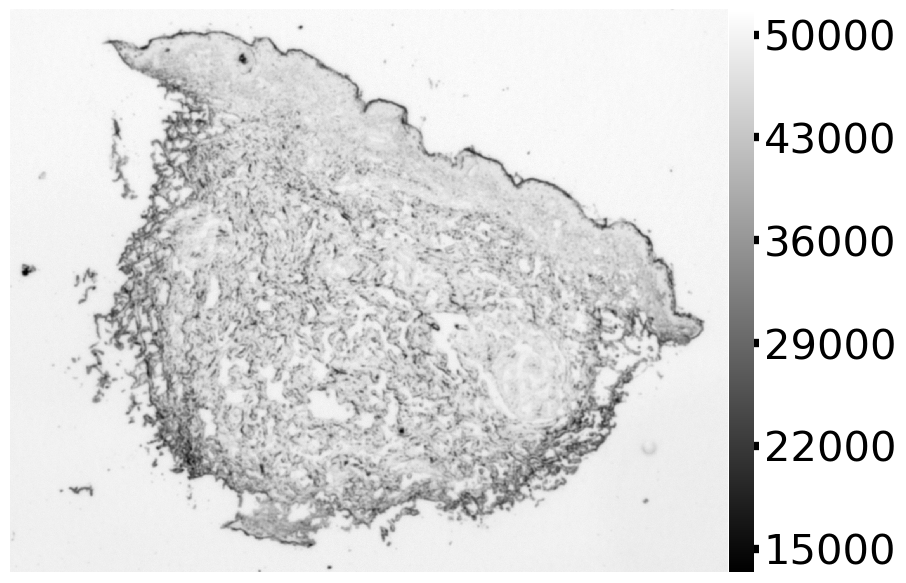

In [4]:
# Load and crop HH image
P10_HHraw_s = tiff.imread("K:\Eric Min_MMP\EricM_MMpolarimetry (CURRENTLY IN USE)\Polarimetry project MBP\Registered\April 3 2025\HEDS\P10\HH.tif")
P10_HH_s = np.array(P10_HHraw_s, dtype='long')  # use np.array instead of matrix
P10_HH_resized = P10_HH_s[50:1900, 300:1750]

# Rotate 90 degrees clockwise
P10_HH_rotated = np.rot90(P10_HH_resized, k=3)

# Calculate min and max for color limits
vmin_val = np.min(P10_HH_rotated)
vmax_val = np.max(P10_HH_rotated)

# Create figure and axis with fixed size
fig, ax = plt.subplots(figsize=(8, 6))

# Display the image
img = ax.imshow(P10_HH_rotated, interpolation='nearest', cmap='gray', vmin=vmin_val, vmax=vmax_val)

# Create a divider and append a colorbar axis of matching height
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define ticks for colorbar (e.g. 6 evenly spaced)
tick_values = np.linspace(15000, 50000, 6)

# Add colorbar with specified ticks
cbar = fig.colorbar(img, cax=cax, ticks=tick_values)

# Increase tick label font size and thickness of tick lines
cbar.ax.tick_params(labelsize=30, width=6)

# Custom tick formatter to clean trailing zeros and decimals
def clean_tick_label(x, pos):
    if np.isclose(x, 0):
        return "0"
    s = f"{x:.10f}".rstrip('0').rstrip('.')
    return s

cbar.ax.yaxis.set_major_formatter(FuncFormatter(clean_tick_label))

# Remove colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Remove axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)

plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  58   58   58 ... 1847 1848 1848] [804 805 806 ... 716 714 715]


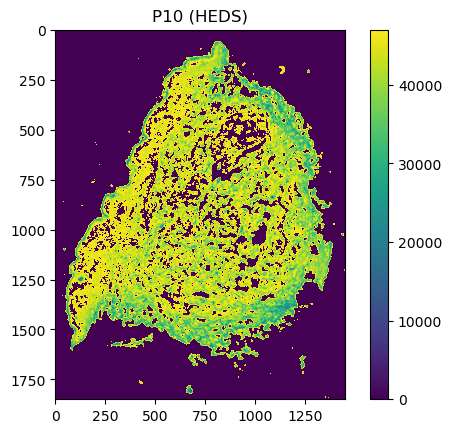

In [5]:
# Thresholding to remove background#
# Create the mask (vary threshold for every sample)
mask = P10_HH_resized < 47000

# Apply the mask
P10_HH_resized = np.where(mask, P10_HH_resized, 0)
valid_row_indices, valid_col_indices = np.nonzero(P10_HH_resized)

print(P10_HH_resized)
print(valid_row_indices, valid_col_indices)
plt.imshow(P10_HH_resized, interpolation='nearest') # Nearest interpolation for just resizing 
plt.colorbar() 
plt.title("P10 (HEDS)")
plt.show()

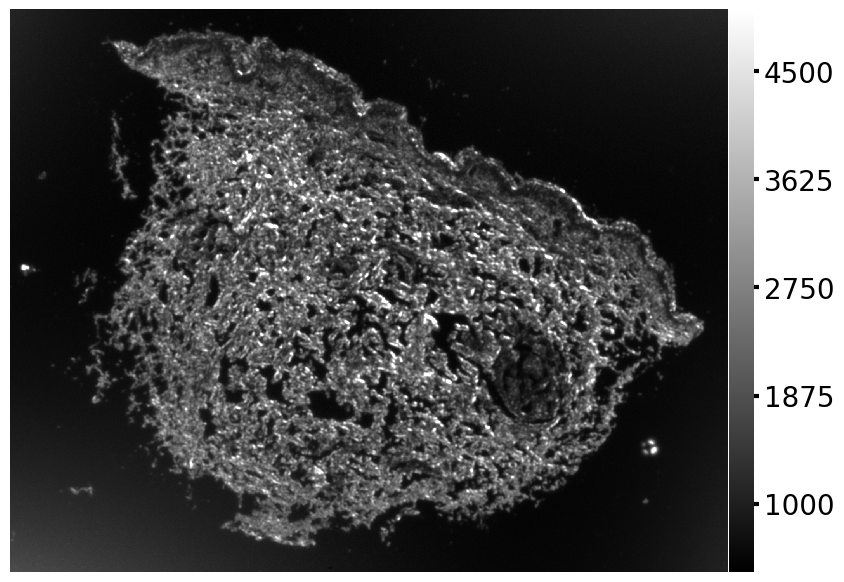

In [6]:
# Load and crop RL image #
P10_RLraw_s = tiff.imread(r"K:\Eric Min_MMP\EricM_MMpolarimetry (CURRENTLY IN USE)\Polarimetry project MBP\Registered\April 3 2025\HEDS\P10\RL.tif")
P10_RL_s = np.array(P10_RLraw_s, dtype='long')
P10_RL_resized = P10_RL_s[50:1900, 300:1750]

# Rotate 90 degrees clockwise
P10_RL_rotated = np.rot90(P10_RL_resized, k=3)

# Determine vmin and fixed vmax
vmin_val = np.min(P10_RL_rotated)
vmax_val = 5000 

# Create figure and axis with fixed size for better control
fig, ax = plt.subplots(figsize=(8, 6))

# Display the image with fixed vmax and automatic vmin
img = ax.imshow(P10_RL_rotated, interpolation='nearest', cmap='gray', vmin=vmin_val, vmax=vmax_val)

# Create a divider and append a colorbar axis of matching height
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define ticks: 6 evenly spaced between vmin and vmax
tick_values = np.linspace(1000, 4500, 5)

# Add colorbar with these ticks
cbar = fig.colorbar(img, cax=cax, ticks=tick_values)

# Increase tick label font size and tick thickness
cbar.ax.tick_params(labelsize=20, width=3)

# Custom formatter to clean trailing zeros
def clean_tick_label(x, pos):
    if np.isclose(x, 0):
        return "0"
    s = f"{x:.10f}".rstrip('0').rstrip('.')
    return s

cbar.ax.yaxis.set_major_formatter(FuncFormatter(clean_tick_label))

# Remove colorbar outline (spines)
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)

plt.show()

In [7]:
# Preliminary cropping #
shape = np.shape(P10_HH_resized)

# Define the cropping parameters as constants --> apparently these are cropping parameters
CROP_Y_START = 50
CROP_Y_END = 1900
CROP_X_START = 300
CROP_X_END = 1750

In [8]:
# Step 1: Use the HH tissue mask (already thresholded)
# P10_HH_resized has been thresholded: values are 0 in background, >0 in tissue
tissue_mask = P10_HH_resized > 0  # Boolean mask, same shape as cropped images

# Step 2: Apply this mask to all images (preserve shape, zero background)
base_path = 'K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\Registered\\April 3 2025\\HEDS\\P10\\blank\\'
labels = ['HH', 'HV', 'HP', 'HB', 'HR', 'HL', 'VH', 'VV', 'VP', 'VB', 'VR', 'VL', 'BH', 'BV', 'BP', 'BB', 'BR', 'BL', 'RH', 'RV', 'RP', 'RB', 'RR', 'RL']

P10_blanks = {}

for label in labels:
    filepath = f'{base_path}{label}.tif'
    data = tiff.imread(filepath)
    P10_blanks[f'P10_{label}_a'] = np.matrix(data, dtype='long')[CROP_Y_START:CROP_Y_END, CROP_X_START:CROP_X_END]
    P10_blanks[f'P10_{label}_a'] = np.where(tissue_mask, P10_blanks[f'P10_{label}_a'], 0)
    
P10_HH_a = P10_blanks['P10_HH_a']
P10_HV_a = P10_blanks['P10_HV_a']
P10_HP_a = P10_blanks['P10_HP_a']
P10_HB_a = P10_blanks['P10_HB_a']
P10_HR_a = P10_blanks['P10_HR_a']
P10_HL_a = P10_blanks['P10_HL_a']

P10_VH_a = P10_blanks['P10_VH_a']
P10_VV_a = P10_blanks['P10_VV_a']
P10_VP_a = P10_blanks['P10_VP_a']
P10_VB_a = P10_blanks['P10_VB_a']
P10_VR_a = P10_blanks['P10_VR_a']
P10_VL_a = P10_blanks['P10_VL_a']

P10_BH_a = P10_blanks['P10_BH_a']
P10_BV_a = P10_blanks['P10_BV_a']
P10_BP_a = P10_blanks['P10_BP_a']
P10_BB_a = P10_blanks['P10_BB_a']
P10_BR_a = P10_blanks['P10_BR_a']
P10_BL_a = P10_blanks['P10_BL_a']

P10_RH_a = P10_blanks['P10_RH_a']
P10_RV_a = P10_blanks['P10_RV_a']
P10_RP_a = P10_blanks['P10_RP_a']
P10_RB_a = P10_blanks['P10_RB_a']
P10_RR_a = P10_blanks['P10_RR_a']
P10_RL_a = P10_blanks['P10_RL_a']


In [9]:
# Get components of input Stokes vector #
H_in_10 = Stokes_dict_in(P10_HH_a, P10_HV_a, P10_HP_a, P10_HB_a, P10_HR_a, P10_HL_a)
H_Iin_10= np.array(H_in_10['Iin'])
H_Qin_10= np.array(H_in_10['Qin'])
H_Uin_10= np.array(H_in_10['Uin'])
H_Vin_10= np.array(H_in_10['Vin'])

B_in_10 = Stokes_dict_in(P10_BH_a, P10_BV_a, P10_BP_a, P10_BB_a, P10_BR_a, P10_BL_a)
B_Iin_10= np.array(B_in_10['Iin'])
B_Qin_10= np.array(B_in_10['Qin'])
B_Uin_10= np.array(B_in_10['Uin'])
B_Vin_10= np.array(B_in_10['Vin'])

V_in_10 = Stokes_dict_in(P10_VH_a, P10_VV_a, P10_VP_a, P10_VB_a, P10_VR_a, P10_VL_a)
V_Iin_10= np.array(V_in_10['Iin'])
V_Qin_10= np.array(V_in_10['Qin'])
V_Uin_10= np.array(V_in_10['Uin'])
V_Vin_10= np.array(V_in_10['Vin'])

R_in_10 = Stokes_dict_in(P10_RH_a, P10_RV_a, P10_RP_a, P10_RB_a, P10_RR_a, P10_RL_a)
R_Iin_10= np.array(R_in_10['Iin'])
R_Qin_10= np.array(R_in_10['Qin'])
R_Uin_10= np.array(R_in_10['Uin'])
R_Vin_10= np.array(R_in_10['Vin'])


In [10]:
# To extract the input Stokes vector 
Sin_10 = np.empty(shape, dtype=object)

for i in range(shape[0]):
    for j in range(shape[1]):
        if tissue_mask[i, j]:
            Sin_10[i][j] = np.array([
                [H_Iin_10[i][j], B_Iin_10[i][j], V_Iin_10[i][j], R_Iin_10[i][j]],
                [H_Qin_10[i][j], B_Qin_10[i][j], V_Qin_10[i][j], R_Qin_10[i][j]],
                [H_Uin_10[i][j], B_Uin_10[i][j], V_Uin_10[i][j], R_Uin_10[i][j]],
                [H_Vin_10[i][j], B_Vin_10[i][j], V_Vin_10[i][j], R_Vin_10[i][j]]
            ])
        else:
            Sin_10[i][j] = None

# Get inverse input Stokes vector for MM calculation

Sin_10_inv = np.empty(shape, dtype=object)

for i in range(shape[0]):
    for j in range(shape[1]):
        if tissue_mask[i, j]:
            try:
                Sin_10_inv[i][j] = np.linalg.inv(Sin_10[i][j])
            except np.linalg.LinAlgError:
                Sin_10_inv[i][j] = None  # Singular matrix
        else:
            Sin_10_inv[i][j] = None
            


In [11]:
# Sanity Check #
print(Sin_10)
print(Sin_10_inv)
non_none = [Sin_10_inv[i][j] for i in range(shape[0]) for j in range(shape[1]) if Sin_10_inv[i][j] is not None]
non_none_sin = [Sin_10[i][j] for i in range(shape[0]) for j in range(shape[1]) if Sin_10[i][j] is not None]
print(f"Number of invertible matrices (Sin_inv): {len(non_none)}")
print(f"Number of invertible matrices (Sin): {len(non_none_sin)}")


[[None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]
 ...
 [None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
[[None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]
 ...
 [None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
Number of invertible matrices (Sin_inv): 1110564
Number of invertible matrices (Sin): 1110564


In [12]:
# Process Images

# P10 DATA #

base_path = 'K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\Registered\\April 3 2025\\HEDS\\P10\\'
labels = ['HH', 'HV', 'HP', 'HB', 'HR', 'HL', 'VH', 'VV', 'VP', 'VB', 'VR', 'VL', 'BH', 'BV', 'BP', 'BB', 'BR', 'BL', 'RH', 'RV', 'RP', 'RB', 'RR', 'RL']

P10_images = {}

for label in labels:
    filepath = f'{base_path}{label}.tif'
    data = tiff.imread(filepath)
    P10_images[f'P10_{label}_s'] = np.matrix(data, dtype='long')[CROP_Y_START:CROP_Y_END, CROP_X_START:CROP_X_END]
    P10_images[f'P10_{label}_s'] = np.where(tissue_mask, P10_images[f'P10_{label}_s'], 0)
    
P10_HH_s = P10_images['P10_HH_s']
P10_HV_s = P10_images['P10_HV_s']
P10_HP_s = P10_images['P10_HP_s']
P10_HB_s = P10_images['P10_HB_s']
P10_HR_s = P10_images['P10_HR_s']
P10_HL_s = P10_images['P10_HL_s']

P10_VH_s = P10_images['P10_VH_s']
P10_VV_s = P10_images['P10_VV_s']
P10_VP_s = P10_images['P10_VP_s']
P10_VB_s = P10_images['P10_VB_s']
P10_VR_s = P10_images['P10_VR_s']
P10_VL_s = P10_images['P10_VL_s']

P10_BH_s = P10_images['P10_BH_s']
P10_BV_s = P10_images['P10_BV_s']
P10_BP_s = P10_images['P10_BP_s']
P10_BB_s = P10_images['P10_BB_s']
P10_BR_s = P10_images['P10_BR_s']
P10_BL_s = P10_images['P10_BL_s']

P10_RH_s = P10_images['P10_RH_s']
P10_RV_s = P10_images['P10_RV_s']
P10_RP_s = P10_images['P10_RP_s']
P10_RB_s = P10_images['P10_RB_s']
P10_RR_s = P10_images['P10_RR_s']
P10_RL_s = P10_images['P10_RL_s']



In [13]:
# Get components of output Stokes vector #

H_out_10 = Stokes_dict_out(P10_HH_s, P10_HV_s, P10_HP_s, P10_HB_s, P10_HR_s, P10_HL_s)
H_Iout_10= np.array(H_out_10['Iout'])
H_Qout_10= np.array(H_out_10['Qout'])
H_Uout_10= np.array(H_out_10['Uout'])
H_Vout_10= np.array(H_out_10['Vout'])

B_out_10 = Stokes_dict_out(P10_BH_s, P10_BV_s, P10_BP_s, P10_BB_s, P10_BR_s, P10_BL_s)
B_Iout_10= np.array(B_out_10['Iout'])
B_Qout_10= np.array(B_out_10['Qout'])
B_Uout_10= np.array(B_out_10['Uout'])
B_Vout_10= np.array(B_out_10['Vout'])

V_out_10 = Stokes_dict_out(P10_VH_s, P10_VV_s, P10_VP_s, P10_VB_s, P10_VR_s, P10_VL_s)
V_Iout_10= np.array(V_out_10['Iout'])
V_Qout_10= np.array(V_out_10['Qout'])
V_Uout_10= np.array(V_out_10['Uout'])
V_Vout_10= np.array(V_out_10['Vout'])

R_out_10 = Stokes_dict_out(P10_RH_s, P10_RV_s, P10_RP_s, P10_RB_s, P10_RR_s, P10_RL_s)
R_Iout_10= np.array(R_out_10['Iout'])
R_Qout_10= np.array(R_out_10['Qout'])
R_Uout_10= np.array(R_out_10['Uout'])
R_Vout_10= np.array(R_out_10['Vout'])


In [14]:
# To extract output Stokes vector #

Sout_10 = np.empty(shape, dtype=object)

for i in range(shape[0]):
    for j in range(shape[1]):
        if tissue_mask[i, j]:
            Sout_10[i][j] = np.array([
                [H_Iout_10[i][j], B_Iout_10[i][j], V_Iout_10[i][j], R_Iout_10[i][j]],
                [H_Qout_10[i][j], B_Qout_10[i][j], V_Qout_10[i][j], R_Qout_10[i][j]],
                [H_Uout_10[i][j], B_Uout_10[i][j], V_Uout_10[i][j], R_Uout_10[i][j]],
                [H_Vout_10[i][j], B_Vout_10[i][j], V_Vout_10[i][j], R_Vout_10[i][j]]
            ])
                
        else:
            Sout_10[i][j] = None


In [15]:
# Sanity Check #
print(Sout_10)
non_none_sout = [Sout_10[i][j] for i in range(shape[0]) for j in range(shape[1]) if Sout_10[i][j] is not None]
print(f"Number of invertible matrices (Sout): {len(non_none_sout)}")


[[None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]
 ...
 [None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
Number of invertible matrices (Sout): 1110564


In [16]:
# Mueller matrix calculation using linear algebra library 
M_10 = np.empty(shape, dtype=object)

# replace Nones with identity matrices 
for i in range(shape[0]):
    for j in range(shape[1]):
        if Sout_10[i][j] is not None and Sin_10_inv[i][j] is not None:
            try:
                M_10[i][j] = np.matmul(Sout_10[i][j], Sin_10_inv[i][j])
            except Exception as e:
                M_10[i][j] = np.eye(4)  # or log e if needed
        else:
            M_10[i][j] = np.eye(4)


In [17]:
# Sanity Check #
print(M_10)
non_none_M = [M_10[i][j] for i in range(shape[0]) for j in range(shape[1]) if M_10[i][j] is not None]
print(f"Number of invertible matrices (M): {len(non_none_M)}")

[[array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]) array([[1., 0., 0., 0.],
                                   [0., 1., 0., 0.],
                                   [0., 0., 1., 0.],
                                   [0., 0., 0., 1.]])
  array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]) ... array([[1., 0., 0., 0.],
                                       [0., 1., 0., 0.],
                                       [0., 0., 1., 0.],
                                       [0., 0., 0., 1.]])
  array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]) array([[1., 0., 0., 0.],
                                   [0., 1., 0., 0.],
                                   [0., 0., 1., 0.],
                                   [0., 0., 0., 1.]])]
 [array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0.

In [18]:
# MM elements -- for each pixel 
M_10_00 = np.ndarray(shape, dtype = float)
M_10_01 = np.ndarray(shape, dtype = float)
M_10_02 = np.ndarray(shape, dtype = float)
M_10_03 = np.ndarray(shape, dtype = float)

M_10_10 = np.ndarray(shape, dtype = float)
M_10_11 = np.ndarray(shape, dtype = float)
M_10_12 = np.ndarray(shape, dtype = float)
M_10_13 = np.ndarray(shape, dtype = float)

M_10_20 = np.ndarray(shape, dtype = float)
M_10_21 = np.ndarray(shape, dtype = float)
M_10_22 = np.ndarray(shape, dtype = float)
M_10_23 = np.ndarray(shape, dtype = float)

M_10_30 = np.ndarray(shape, dtype = float)
M_10_31 = np.ndarray(shape, dtype = float)
M_10_32 = np.ndarray(shape, dtype = float)
M_10_33 = np.ndarray(shape, dtype = float)

for i in range(shape[0]):
    for j in range(shape[1]):
        
        M_10_00[i][j] = M_10[i][j][0][0]
        M_10_01[i][j] = M_10[i][j][0][1]
        M_10_02[i][j] = M_10[i][j][0][2]
        M_10_03[i][j] = M_10[i][j][0][3]
        
        M_10_10[i][j] = M_10[i][j][1][0]
        M_10_11[i][j] = M_10[i][j][1][1]
        M_10_12[i][j] = M_10[i][j][1][2]
        M_10_13[i][j] = M_10[i][j][1][3]
        
        M_10_20[i][j] = M_10[i][j][2][0]
        M_10_21[i][j] = M_10[i][j][2][1]
        M_10_22[i][j] = M_10[i][j][2][2]
        M_10_23[i][j] = M_10[i][j][2][3]
        
        M_10_30[i][j] = M_10[i][j][3][0]
        M_10_31[i][j] = M_10[i][j][3][1]
        M_10_32[i][j] = M_10[i][j][3][2]
        M_10_33[i][j] = M_10[i][j][3][3]




In [19]:
# Sanity Check #
print(M_10_11)
print(M_10_11.shape)
non_one_M_00 = [M_10_11[i][j] for i in range(shape[0]) for j in range(shape[1]) if M_10_11[i][j] != 1]
print(f"Number of non-identity matrices (M00): {len(non_one_M_00)}")

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(1850, 1450)
Number of non-identity matrices (M00): 1110564


In [20]:

# Obtain MM elements mean, median, standard deviations, kurtosis, skew#

avg_M_10_00, med_M_10_00, std_M_10_00, kurt_M_10_00, skew_M_10_00 = parameter_stats(M_10_00, tissue_mask)
avg_M_10_01, med_M_10_01, std_M_10_01, kurt_M_10_01, skew_M_10_01 = parameter_stats(M_10_01, tissue_mask)
avg_M_10_02, med_M_10_02, std_M_10_02, kurt_M_10_02, skew_M_10_02 = parameter_stats(M_10_02, tissue_mask)
avg_M_10_03, med_M_10_03, std_M_10_03, kurt_M_10_03, skew_M_10_03 = parameter_stats(M_10_03, tissue_mask)

avg_M_10_10, med_M_10_10, std_M_10_10, kurt_M_10_10, skew_M_10_10 = parameter_stats(M_10_10, tissue_mask)
avg_M_10_11, med_M_10_11, std_M_10_11, kurt_M_10_11, skew_M_10_11 = parameter_stats(M_10_11, tissue_mask)
avg_M_10_12, med_M_10_12, std_M_10_12, kurt_M_10_12, skew_M_10_12 = parameter_stats(M_10_12, tissue_mask)
avg_M_10_13, med_M_10_13, std_M_10_13, kurt_M_10_13, skew_M_10_13 = parameter_stats(M_10_13, tissue_mask)

avg_M_10_20, med_M_10_20, std_M_10_20, kurt_M_10_20, skew_M_10_20 = parameter_stats(M_10_20, tissue_mask)
avg_M_10_21, med_M_10_21, std_M_10_21, kurt_M_10_21, skew_M_10_21 = parameter_stats(M_10_21, tissue_mask)
avg_M_10_22, med_M_10_22, std_M_10_22, kurt_M_10_22, skew_M_10_22 = parameter_stats(M_10_22, tissue_mask)
avg_M_10_23, med_M_10_23, std_M_10_23, kurt_M_10_23, skew_M_10_23 = parameter_stats(M_10_23, tissue_mask)

avg_M_10_30, med_M_10_30, std_M_10_30, kurt_M_10_30, skew_M_10_30 = parameter_stats(M_10_30, tissue_mask)
avg_M_10_31, med_M_10_31, std_M_10_31, kurt_M_10_31, skew_M_10_31 = parameter_stats(M_10_31, tissue_mask)
avg_M_10_32, med_M_10_32, std_M_10_32, kurt_M_10_32, skew_M_10_32 = parameter_stats(M_10_32, tissue_mask)
avg_M_10_33, med_M_10_33, std_M_10_33, kurt_M_10_33, skew_M_10_33 = parameter_stats(M_10_33, tissue_mask)




In [21]:
print(med_M_10_00)
print(avg_M_10_00)
print(std_M_10_00)
print(kurt_M_10_00)
print(skew_M_10_00)
print('-------------------------------------')
print(med_M_10_32)
print(avg_M_10_32)
print(std_M_10_32)
print(kurt_M_10_32)
print(skew_M_10_32)

0.7969207367182052
0.7697378378748532
0.08643038837590555
1.4139854183230316
-1.2878586163889332
-------------------------------------
0.0001329963353435122
-0.0008200521187912465
0.022892078660014747
5.8205520555783075
-0.2814066197944591


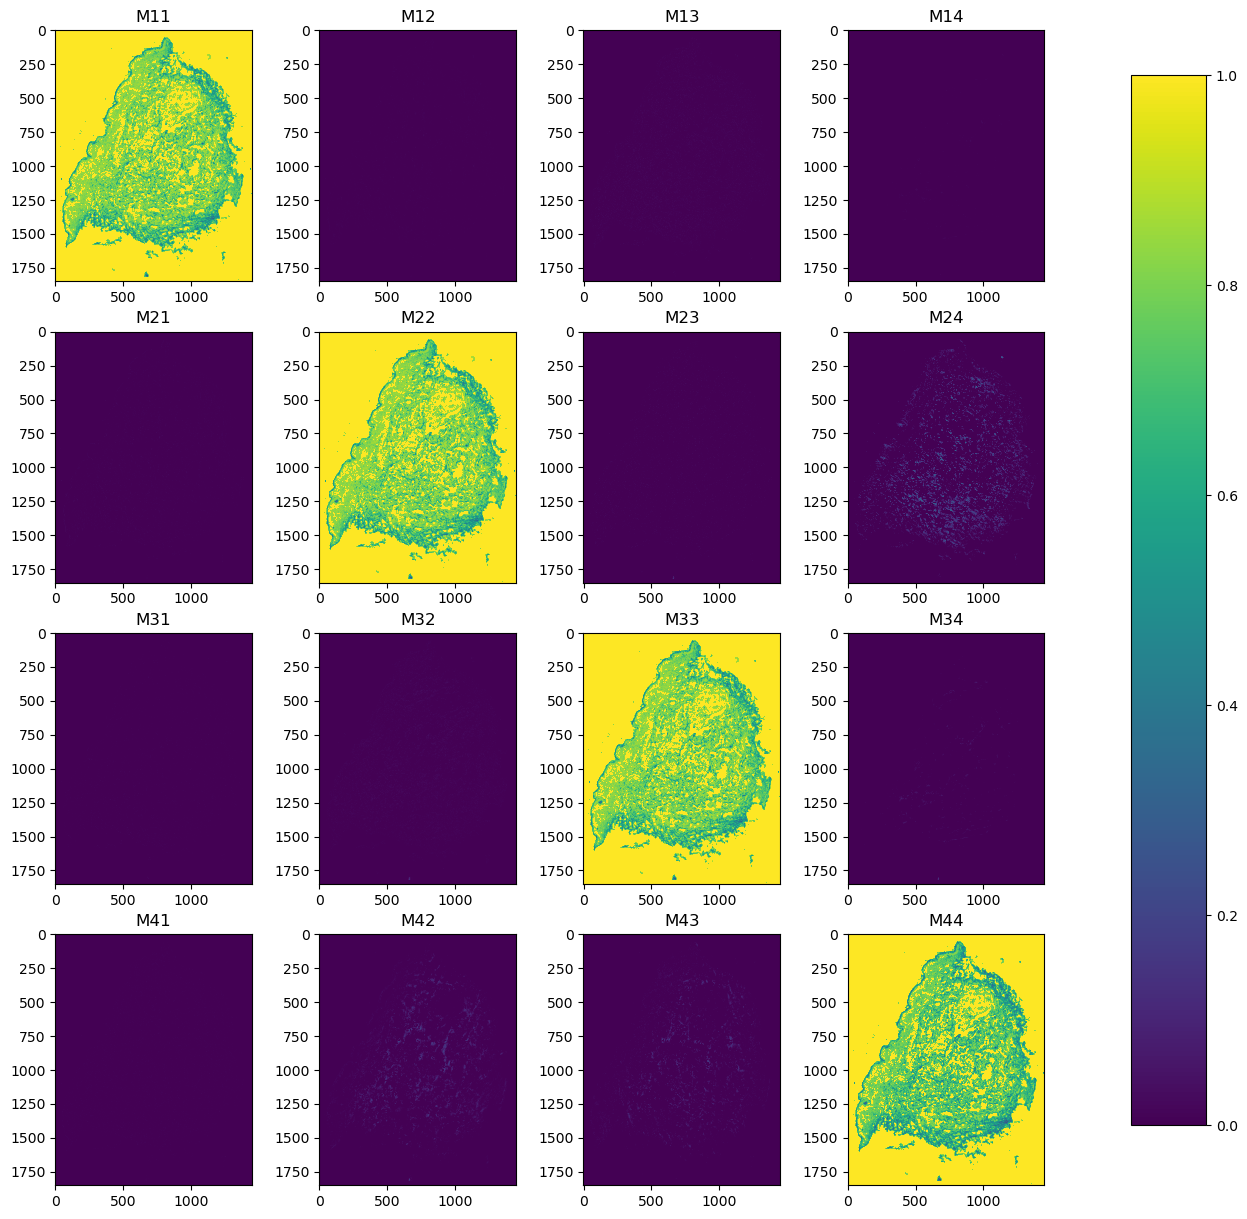

In [22]:
from matplotlib import cm
fig, axs = plt.subplots(4, 4, figsize=(15,15))
for ax in axs.flat:
    im1 = axs[0, 0].imshow(M_10_00, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t1 = axs[0, 0].set_title('M11')
    im2 = axs[0, 1].imshow(M_10_01, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t2 = axs[0, 1].set_title('M12')
    im3 = axs[0, 2].imshow(M_10_02, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t3 = axs[0, 2].set_title('M13')
    im4= axs[0, 3].imshow(M_10_03, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t4 = axs[0, 3].set_title('M14')
    im5 = axs[1, 0].imshow(M_10_10, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t5 = axs[1, 0].set_title('M21')
    im6 = axs[1, 1].imshow(M_10_11, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t6 = axs[1, 1].set_title('M22')
    im7 = axs[1, 2].imshow(M_10_12, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t7 = axs[1, 2].set_title('M23')
    im8 = axs[1, 3].imshow(M_10_13, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t8 = axs[1, 3].set_title('M24')
    im9 = axs[2, 0].imshow(M_10_20, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t9 = axs[2, 0].set_title('M31')
    im10 = axs[2, 1].imshow(M_10_21, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t10 = axs[2, 1].set_title('M32')
    im11 = axs[2, 2].imshow(M_10_22, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t11 = axs[2, 2].set_title('M33')
    im12 = axs[2, 3].imshow(M_10_23, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t12 = axs[2, 3].set_title('M34')
    im13 = axs[3, 0].imshow(M_10_30, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t13 = axs[3, 0].set_title('M41')
    im14 = axs[3, 1].imshow(M_10_31, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t14 = axs[3, 1].set_title('M42')
    im15 = axs[3, 2].imshow(M_10_32, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t15 = axs[3, 2].set_title('M43')
    im16 = axs[3, 3].imshow(M_10_33, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t16 = axs[3, 3].set_title('M44')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)


plt.show()


In [23]:
 # LU CHIPMAN POLAR DECOMPOSITION #

In [24]:
# Assuming HH_resized is your cropped or sliced image array
dimensions_10 = P10_HH_resized.shape

# dimensions will be a tuple like (height, width)
height_10, width_10 = dimensions_10

print("Height:", height_10)
print("Width:", width_10)

Height: 1850
Width: 1450


In [25]:
# Total Retardance #
Meller_matrix_10 = np.ndarray((height_10, width_10), dtype = object)
LuCh_10 = np.ndarray((height_10, width_10), dtype = object)
Mdepol_10 = np.ndarray((height_10, width_10), dtype = object)  # Depolarizer matrix
Mret_10 = np.ndarray((height_10, width_10), dtype = object)   # Retarder matrix
Mdiatten_10 = np.ndarray((height_10, width_10), dtype = object)   # Diattenuator matrix
T_10 = np.ndarray((height_10, width_10), dtype = float)  
Retardance_10 = np.ndarray((height_10, width_10), dtype = float)

for k in range(height_10):
    for m in range(width_10):
        Meller_matrix_10[k][m] = MuellerMatrix(M_10[k][m]) 
        LuCh_10[k][m] = Lu_Chipman_Decomposition(Meller_matrix_10[k][m])
        Mdepol_10[k][m], Mret_10[k][m], Mdiatten_10[k][m] = LuCh_10[k][m] 
        T_10[k][m] = np.trace(Mret_10[k][m])/2-1
        if T_10[k][m] > 1:
            Retardance_10[k][m] = math.acos(1)  # there are values >1 and < -1
        elif T_10[k][m] < -1:
            Retardance_10[k][m] = math.acos(1)  # mathematically it's 180˚ but physically 0˚
        else:
            Retardance_10[k][m] = math.acos(T_10[k][m])



In [26]:
# Linear retardance #

LinearRetardance_10 = np.ndarray((height_10, width_10), dtype=float)
values_before_acos_10 = np.ndarray((height_10, width_10), dtype=float)  # Array to store the values before acos

for k in range(height_10):
    for m in range(width_10):
        Meller_matrix_10[k][m] = MuellerMatrix(M_10[k][m]) 
        LuCh_10[k][m] = Lu_Chipman_Decomposition(Meller_matrix_10[k][m])
        Mdepol_10[k][m], Mret_10[k][m], Mdiatten_10[k][m] = LuCh_10[k][m]
        
        # Calculate the value for acos
        temp_value = (Mret_10[k][m][1][1] + Mret_10[k][m][2][2])**2 + (Mret_10[k][m][2][1] - Mret_10[k][m][1][2])**2
        temp_value = math.sqrt(temp_value) - 1

        # Clamp the value to be within [-1, 1]
        clamped_value = max(min(temp_value, 1), -1)
        
        # Store the clamped value
        values_before_acos_10[k][m] = clamped_value

        # Calculate the Linear Retardance
        LinearRetardance_10[k][m] = math.acos(clamped_value)



In [27]:
# Mueller matrix polar decomposition (MMPD) parameters
Md_10 = np.ndarray((height_10, width_10), dtype = float)
Depol_10 = np.ndarray((height_10, width_10), dtype = float)
opt_rot_10 = np.ndarray((height_10, width_10), dtype = float)

for k in range(height_10):
    for m in range(width_10):
        Meller_matrix_10[k][m] = MuellerMatrix(M_10[k][m]) 
        LuCh_10[k][m] = Lu_Chipman_Decomposition(Meller_matrix_10[k][m])
        Mdepol_10[k][m], Mret_10[k][m], Mdiatten_10[k][m] = LuCh_10[k][m]
    

        # Depolarization
#         Md[k][m] = Mdepol[k][m]-1
        Depol_10[k][m] = 1 - abs(((Mdepol_10[k][m]-1).trace()))/3
        Depolarization = pd.DataFrame(Depol_10)
        
        # Optical Rotation (had "-" in the denominator)
        phi = math.atan((Mret_10[k][m][2][1]-Mret_10[k][m][1][2])/(Mret_10[k][m][1][1]+Mret_10[k][m][2][2]))
        opt_rot_10[k][m] = np.where(phi < -np.pi/4, phi + np.pi/4, phi) # limit range to -pi/4 and pi/4 as defined

# OBTAIN STATS #
avg_Depol_10, med_Depol_10, std_Depol_10, kurt_Depol_10, skew_Depol_10 = parameter_stats(Depol_10, tissue_mask)
avg_opt_rot_10, med_opt_rot_10, std_opt_rot_10, kurt_opt_rot_10, skew_opt_rot_10 = parameter_stats(opt_rot_10, tissue_mask)



In [28]:
# Retardance, Linear Retardance in degree 
deg_ret_10 = np.ndarray((height_10, width_10), dtype = float)
deg_l_ret_10 = np.ndarray((height_10, width_10), dtype = float)
# Diattenuation 
diattenuation_10 = np.ndarray((height_10, width_10), dtype = float)

for k in range(height_10):
    for m in range(width_10):
        deg_ret_10[k][m] = math.degrees(Retardance_10[k][m])
        deg_l_ret_10[k][m] = math.degrees(LinearRetardance_10[k][m])
        diattenuation_10[k][m] = (math.sqrt(M_10[k][m][0][1]**2+M_10[k][m][0][2]**2+M_10[k][m][0][3]**2)) 

# OBTAIN STATS #
avg_deg_ret_10, med_deg_ret_10, std_deg_ret_10, kurt_deg_ret_10, skew_deg_ret_10 = parameter_stats(deg_ret_10, tissue_mask)
avg_deg_l_ret_10, med_deg_l_ret_10, std_deg_l_ret_10, kurt_deg_l_ret_10, skew_deg_l_ret_10 = parameter_stats(deg_l_ret_10, tissue_mask)
avg_diattenuation_10, med_diattenuation_10, std_diattenuation_10, kurt_diattenuation_10, skew_diattenuation_10 = parameter_stats(diattenuation_10, tissue_mask)

In [29]:
########### Mueller matrix transformation parameters (MMT) ###########
A_10 = np.ndarray((height_10, width_10), dtype = float)
b_10 = np.ndarray((height_10, width_10), dtype = float)
anisotropy_degree_10 = np.ndarray((height_10, width_10), dtype = float)
beta_10 = np.ndarray((height_10, width_10), dtype = float)

########### Mueller matrix rotation invariant parameters (MMRI) ###########
q_L_10 = np.ndarray((height_10, width_10), dtype = float) 
circular_to_linear_10 = np.ndarray((height_10, width_10), dtype = float) 
Linear_polar_10 = np.ndarray((height_10, width_10), dtype = float) 
Linear_diat_10 = np.ndarray((height_10, width_10), dtype = float) 
x_10 = np.ndarray((height_10, width_10), dtype = float) # Negated in paper due to bimodal distribution of results
# Dc is given by m14 and Pc by m41

# Calculated in one loop 
for k in range(height_10):
    for m in range(width_10):
        b_10[k][m] = (M_10[k][m][1][1]+M_10[k][m][2][2])/2  # Polarizance
        anisotropy_degree_10[k][m] = math.sqrt((M_10[k][m][1][1]-M_10[k][m][2][2])**2+(M_10[k][m][1][2]+M_10[k][m][2][1])**2)/2   # Anisotropy degree 
        A_10[k][m] = 2*b_10[k][m]*anisotropy_degree_10[k][m]/(b_10[k][m]**2+anisotropy_degree_10[k][m]**2) # Normalized anisotropy 
        q_L_10[k][m] = math.sqrt((M_10[k][m][3][1])**2+(M_10[k][m][3][2])**2)  # capability of transforming from linear to circular polarizations
        if M_10[k][m][0][1] == 0:
            theta = 0
        else:
            theta = (math.atan(M_10[k][m][0][2]/M_10[k][m][0][1]))/2
        x_10[k][m] = np.where(theta < -np.pi/4, theta + np.pi/4, theta)  
        circular_to_linear_10[k][m] = math.sqrt((M_10[k][m][1][3])**2+(M_10[k][m][2][3])**2) # capability of transforming from circular to linear polarizations
        Linear_polar_10[k][m] = math.sqrt((M_10[k][m][1][0])**2+(M_10[k][m][2][0])**2) # Linear polarizance (same as p_L)
        Linear_diat_10[k][m] = math.sqrt((M_10[k][m][0][1])**2+(M_10[k][m][0][2])**2) # Linear diattenuation
        beta_10[k][m] = abs(M_10[k][m][1][2] - M_10[k][m][2][1])/2  # circular birefringence 

        
# PARAMETER STATS #
avg_beta_10, med_beta_10, std_beta_10, kurt_beta_10, skew_beta_10 = parameter_stats(beta_10, tissue_mask)
avg_anisotropy_degree_10, med_anisotropy_degree_10, std_anisotropy_degree_10, kurt_anisotropy_degree_10, skew_anisotropy_degree_10 = parameter_stats(anisotropy_degree_10, tissue_mask)
avg_b_10, med_b_10, std_b_10, kurt_b_10, skew_b_10 = parameter_stats(b_10, tissue_mask)
avg_A_10, med_A_10, std_A_10, kurt_A_10, skew_A_10 = parameter_stats(A_10, tissue_mask)
avg_x_10, med_x_10, std_x_10, kurt_x_10, skew_x_10 = parameter_stats(x_10, tissue_mask)
avg_q_L_10, med_q_L_10, std_q_L_10, kurt_q_L_10, skew_q_L_10 = parameter_stats(q_L_10, tissue_mask)
avg_circular_to_linear_10, med_circular_to_linear_10, std_circular_to_linear_10, kurt_circular_to_linear_10, skew_circular_to_linear_10 = parameter_stats(circular_to_linear_10, tissue_mask)
avg_Linear_polar_10, med_Linear_polar_10, std_Linear_polar_10, kurt_Linear_polar_10, skew_Linear_polar_10 = parameter_stats(Linear_polar_10, tissue_mask)
avg_Linear_diat_10, med_Linear_diat_10, std_Linear_diat_10, kurt_Linear_diat_10, skew_Linear_diat_10 = parameter_stats(Linear_diat_10, tissue_mask)


In [30]:
# MMLI parameters
p_L_10 = np.ndarray((height_10, width_10), dtype = float)
p_1_10 = np.ndarray((height_10, width_10), dtype = float)
p_2_10 = np.ndarray((height_10, width_10), dtype = float)
p_3_10 = np.ndarray((height_10, width_10), dtype = float)
p_4_10 = np.ndarray((height_10, width_10), dtype = float)
p_5_10 = np.ndarray((height_10, width_10), dtype = float)
p_6_10 = np.ndarray((height_10, width_10), dtype = float)
p_7_10 = np.ndarray((height_10, width_10), dtype = float)
p_8_10 = np.ndarray((height_10, width_10), dtype = float)
p_tms_10 = np.ndarray((height_10, width_10), dtype = float)

for k in range(height_10):
    for m in range(width_10):
        p_L_10[k][m] = math.sqrt((M_10[k][m][1][0])**2+(M_10[k][m][2][0])**2)
        
        p_1_10[k][m] = (M_10[k][m][3][2]+M_10[k][m][2][3])/2
        
        p_2_10[k][m] = (M_10[k][m][3][1]+M_10[k][m][1][3])/2
        
        p_3_10[k][m] = abs(circular_to_linear_10[k][m]-q_L_10[k][m])
        
        p_4_10[k][m] = ((M_10[k][m][2][3]*M_10[k][m][1][3])-(M_10[k][m][3][1]*M_10[k][m][3][2]))/2
        
        p_5_10[k][m] = (M_10[k][m][0][1]-M_10[k][m][1][0])/2 
        
        p_6_10[k][m] = (M_10[k][m][0][2]-M_10[k][m][2][0])/3   
        
        p_7_10[k][m] = abs(Linear_diat_10[k][m]-p_L_10[k][m])
        
        p_8_10[k][m] = ((M_10[k][m][0][1]*M_10[k][m][0][2])-(M_10[k][m][1][0]*M_10[k][m][2][0]))/2
        
        p_tms_10[k][m] = math.sqrt((p_1_10[k][m])**2 + (p_2_10[k][m])**2)
        

# STATS #
avg_p_L_10, med_p_L_10, std_p_L_10, kurt_p_L_10, skew_p_L_10 = parameter_stats(p_L_10, tissue_mask)
avg_p_1_10, med_p_1_10, std_p_1_10, kurt_p_1_10, skew_p_1_10 = parameter_stats(p_1_10, tissue_mask)
avg_p_2_10, med_p_2_10, std_p_2_10, kurt_p_2_10, skew_p_2_10 = parameter_stats(p_2_10, tissue_mask)
avg_p_3_10, med_p_3_10, std_p_3_10, kurt_p_3_10, skew_p_3_10 = parameter_stats(p_3_10, tissue_mask)
avg_p_4_10, med_p_4_10, std_p_4_10, kurt_p_4_10, skew_p_4_10 = parameter_stats(p_4_10, tissue_mask)
avg_p_5_10, med_p_5_10, std_p_5_10, kurt_p_5_10, skew_p_5_10 = parameter_stats(p_5_10, tissue_mask)
avg_p_6_10, med_p_6_10, std_p_6_10, kurt_p_6_10, skew_p_6_10 = parameter_stats(p_6_10, tissue_mask)
avg_p_7_10, med_p_7_10, std_p_7_10, kurt_p_7_10, skew_p_7_10 = parameter_stats(p_7_10, tissue_mask)
avg_p_8_10, med_p_8_10, std_p_8_10, kurt_p_8_10, skew_p_8_10 = parameter_stats(p_8_10, tissue_mask)
avg_p_tms_10, med_p_tms_10, std_p_tms_10, kurt_p_tms_10, skew_p_tms_10 = parameter_stats(p_tms_10, tissue_mask)




In [31]:
# # CREATE NEW FILE (comment out after running once)#
# df_empty = pd.DataFrame({'Sample':[],
#                     'Status': [],
#                     'M11 (median)': [], 
#                     'M11 (mean)': [],
#                     'M11 (std)': [],
#                     'M11 (kurtosis)' :[],
#                     'M11 (skew)' :[],
#                     'M12 (median)': [],
#                     'M12 (mean)': [],
#                     'M12 (std)': [],
#                     'M12 (kurtosis)' :[],
#                     'M12 (skew)' :[],
#                     'M13 (median)': [],
#                     'M13 (mean)': [],
#                     'M13 (std)': [],
#                     'M13 (kurtosis)' :[],
#                     'M13 (skew)' :[],
#                     'M14 (median)': [],
#                     'M14 (mean)': [],
#                     'M14 (std)': [],
#                     'M14 (kurtosis)' :[],
#                     'M14 (skew)' :[],
#                     'M21 (median)': [],
#                     'M21 (mean)': [],
#                     'M21 (std)': [],
#                     'M21 (kurtosis)' :[],
#                     'M21 (skew)' :[],
#                     'M22 (median)': [],
#                     'M22 (mean)': [],
#                     'M22 (std)': [],
#                     'M22 (kurtosis)' :[],
#                     'M22 (skew)' :[],
#                     'M23 (median)': [],
#                     'M23 (mean)': [],
#                     'M23 (std)': [],
#                     'M23 (kurtosis)' :[],
#                     'M23 (skew)' :[],
#                     'M24 (median)': [],
#                     'M24 (mean)': [],
#                     'M24 (std)': [],
#                     'M24 (kurtosis)' :[],
#                     'M24 (skew)' :[],
#                     'M31 (median)': [],
#                     'M31 (mean)': [],
#                     'M31 (std)': [],
#                     'M31 (kurtosis)' :[],
#                     'M31 (skew)' :[],
#                     'M32 (median)': [],
#                     'M32 (mean)': [],
#                     'M32 (std)': [],
#                     'M32 (kurtosis)' :[],
#                     'M32 (skew)' :[],
#                     'M33 (median)': [],
#                     'M33 (mean)': [],
#                     'M33 (std)': [],
#                     'M33 (kurtosis)' :[],
#                     'M33 (skew)' :[],
#                     'M34 (median)': [],
#                     'M34 (mean)': [],
#                     'M34 (std)': [],
#                     'M34 (kurtosis)' :[],
#                     'M34 (skew)' :[],
#                     'M41 (median)': [],
#                     'M41 (mean)': [],
#                     'M41 (std)': [],
#                     'M41 (kurtosis)' :[],
#                     'M41 (skew)' :[],
#                     'M42 (median)': [],
#                     'M42 (mean)': [],
#                     'M42 (std)': [],
#                     'M42 (kurtosis)' :[],
#                     'M42 (skew)' :[],
#                     'M43 (median)': [],
#                     'M43 (mean)': [],
#                     'M43 (std)': [],
#                     'M43 (kurtosis)' :[],
#                     'M43 (skew)' :[],
#                     'M44 (median)': [],
#                     'M44 (mean)': [],
#                     'M44 (std)': [],
#                     'M44 (kurtosis)' :[],
#                     'M44 (skew)' :[],
#                     'Retardance (median)':[],
#                     'Retardance (mean)':[],
#                     'Retardance (std)':[],
#                     'Retardance (kurtosis)':[],
#                     'Retardance (skew)':[],
#                     'Linear Retardance (median)':[],
#                     'Linear Retardance (mean)':[],
#                     'Linear Retardance (std)':[],
#                     'Linear Retardance (kurtosis)':[],
#                     'Linear Retardance (skew)':[],
#                     'Diattenuation (median)':[],
#                     'Diattenuation (mean)':[],
#                     'Diattenuation (std)':[],
#                     'Diattenuation (kurtosis)':[],
#                     'Diattenuation (skew)':[],
#                     'Depolarization (median)': [],
#                     'Depolarization (mean)': [],
#                     'Depolarization (std)': [],
#                     'Depolarization (kurtosis)': [],
#                     'Depolarization (skew)': [],
#                     'A (median)': [],
#                     'A (mean)': [],
#                     'A (std)': [],
#                     'A (kurtosis)': [],
#                     'A (skew)': [],
#                     'b (median)':[],
#                     'b (mean)':[],
#                     'b (std)':[],
#                     'b (kurtosis)':[],
#                     'b (skew)':[],
#                     'Anisotropy degree (median)':[],
#                     'Anisotropy degree (mean)':[],
#                     'Anisotropy degree (std)':[],
#                     'Anisotropy degree (kurtosis)':[],
#                     'Anisotropy degree (skew)':[],
#                     'q_L (median)':[],
#                     'q_L (mean)':[],
#                     'q_L (std)':[],
#                     'q_L (kurtosis)':[],
#                     'q_L (skew)':[],
#                     "x (median)": [],
#                     "x (mean)": [], 
#                     "x (std)": [],
#                     "x (kurtosis)": [], 
#                     "x (skew)": [],
#                     "circular_to_linear (median)":[],
#                     "circular_to_linear (mean)":[],
#                     "circular_to_linear (std)":[],
#                     "circular_to_linear (kurtosis)":[],
#                     "circular_to_linear (skew)":[],
#                     "Linear_polar (median)":[],
#                     "Linear_polar (mean)":[], 
#                     "Linear_polar (std)":[],
#                     "Linear_polar (kurtosis)":[], 
#                     "Linear_polar (skew)":[],
#                     "Linear_diat (median)":[],
#                     "Linear_diat (mean)":[],
#                     "Linear_diat (std)":[],
#                     "Linear_diat (kurtosis)":[],
#                     "Linear_diat (skew)":[],
#                     "beta (median)":[],
#                     "beta (mean)":[],
#                     "beta (std)":[],
#                      "beta (kurtosis)":[],
#                     "beta (skew)":[],
#                     "opt_rot (median)":[], 
#                     "opt_rot (mean)":[], 
#                     "opt_rot (std)":[],
#                     "opt_rot (kurtosis)":[], 
#                     "opt_rot (skew)":[],
#                     "p_L (median)":[], 
#                     "p_L (mean)":[], 
#                     "p_L (std)":[],
#                     "p_L (kurtosis)":[], 
#                     "p_L (skew)":[],
#                     "p_1 (median)":[], 
#                     "p_1 (mean)":[],
#                     "p_1 (std)":[],
#                     "p_1 (kurtosis)":[],
#                     "p_1 (skew)":[],
#                     "p_2 (median)":[],
#                     "p_2 (mean)":[], 
#                     "p_2 (std)":[],
#                     "p_2 (kurtosis)":[], 
#                     "p_2 (skew)":[],
#                     "p_3 (median)":[], 
#                     "p_3 (mean)":[], 
#                     "p_3 (std)":[],
#                     "p_3 (kurtosis)":[], 
#                     "p_3 (skew)":[],
#                     "p_4 (median)":[], 
#                     "p_4 (mean)":[], 
#                     "p_4 (std)":[],
#                     "p_4 (kurtosis)":[], 
#                     "p_4 (skew)":[],
#                     "p_5 (median)":[], 
#                     "p_5 (mean)":[], 
#                     "p_5 (std)":[],
#                     "p_5 (kurtosis)":[], 
#                     "p_5 (skew)":[],
#                     "p_6 (median)":[], 
#                     "p_6 (mean)":[], 
#                     "p_6 (std)":[],
#                     "p_6 (kurtosis)":[], 
#                     "p_6 (skew)":[],
#                     "p_7 (median)":[],
#                     "p_7 (mean)":[],
#                     "p_7 (std)":[],
#                     "p_7 (kurtosis)":[],
#                     "p_7 (skew)":[],
#                     "p_8 (median)":[], 
#                     "p_8 (mean)":[], 
#                     "p_8 (std)":[],
#                     "p_8 (kurtosis)":[], 
#                     "p_8 (skew)":[],
#                     "p_tms (median)":[],
#                     "p_tms (mean)":[],
#                     "p_tms (std)":[],
#                     "p_tms (kurtosis)":[],
#                     "p_tms (skew)":[]})

# # determining the name of the file
# file_name = 'K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\stats_master.xlsx'

# # saving the excel
# df_empty.to_excel(file_name)
# print('DataFrame is written to Excel File successfully.')



In [32]:
# LOADING OF DATA INTO EXCEL #
df_10 = pd.DataFrame({'Sample':['P10'],
                    'Status': ['HEDS'],
                    'M11 (median)': [med_M_10_00], 
                    'M11 (mean)': [avg_M_10_00],
                    'M11 (std)': [std_M_10_00],
                    'M11 (kurtosis)' :[kurt_M_10_00],
                    'M11 (skew)' :[skew_M_10_00],
                    'M12 (median)': [med_M_10_01],
                    'M12 (mean)': [avg_M_10_01],
                    'M12 (std)': [std_M_10_01],
                    'M12 (kurtosis)' :[kurt_M_10_01],
                    'M12 (skew)' :[skew_M_10_01],
                    'M13 (median)': [med_M_10_02],
                    'M13 (mean)': [avg_M_10_02],
                    'M13 (std)': [std_M_10_02],
                    'M13 (kurtosis)' :[kurt_M_10_02],
                    'M13 (skew)' :[skew_M_10_02],
                    'M14 (median)': [med_M_10_03],
                    'M14 (mean)': [avg_M_10_03],
                    'M14 (std)': [std_M_10_03],
                    'M14 (kurtosis)' :[kurt_M_10_03],
                    'M14 (skew)' :[skew_M_10_03],
                    'M21 (median)': [med_M_10_10],
                    'M21 (mean)': [avg_M_10_10],
                    'M21 (std)': [std_M_10_10],
                    'M21 (kurtosis)' :[kurt_M_10_10],
                    'M21 (skew)' :[skew_M_10_10],
                    'M22 (median)': [med_M_10_11],
                    'M22 (mean)': [avg_M_10_11],
                    'M22 (std)': [std_M_10_11],
                    'M22 (kurtosis)' :[kurt_M_10_11],
                    'M22 (skew)' :[skew_M_10_11],
                    'M23 (median)': [med_M_10_12],
                    'M23 (mean)': [avg_M_10_12],
                    'M23 (std)': [std_M_10_12],
                    'M23 (kurtosis)' :[kurt_M_10_12],
                    'M23 (skew)' :[skew_M_10_12],
                    'M24 (median)': [med_M_10_13],
                    'M24 (mean)': [avg_M_10_13],
                    'M24 (std)': [std_M_10_13],
                    'M24 (kurtosis)' :[kurt_M_10_13],
                    'M24 (skew)' :[skew_M_10_13],
                    'M31 (median)': [med_M_10_20],
                    'M31 (mean)': [avg_M_10_20],
                    'M31 (std)': [std_M_10_20],
                    'M31 (kurtosis)' :[kurt_M_10_20],
                    'M31 (skew)' :[skew_M_10_20],
                    'M32 (median)': [med_M_10_21],
                    'M32 (mean)': [avg_M_10_21],
                    'M32 (std)': [std_M_10_21],
                    'M32 (kurtosis)' :[kurt_M_10_21],
                    'M32 (skew)' :[skew_M_10_21],
                    'M33 (median)': [med_M_10_22],
                    'M33 (mean)': [avg_M_10_22],
                    'M33 (std)': [std_M_10_22],
                    'M33 (kurtosis)' :[kurt_M_10_22],
                    'M33 (skew)' :[skew_M_10_22],
                    'M34 (median)': [med_M_10_23],
                    'M34 (mean)': [avg_M_10_23],
                    'M34 (std)': [std_M_10_23],
                    'M34 (kurtosis)' :[kurt_M_10_23],
                    'M34 (skew)' :[skew_M_10_23],
                    'M41 (median)': [med_M_10_30],
                    'M41 (mean)': [avg_M_10_30],
                    'M41 (std)': [std_M_10_30],
                    'M41 (kurtosis)' :[kurt_M_10_30],
                    'M41 (skew)' :[skew_M_10_30],
                    'M42 (median)': [med_M_10_31],
                    'M42 (mean)': [avg_M_10_31],
                    'M42 (std)': [std_M_10_31],
                    'M42 (kurtosis)' :[kurt_M_10_31],
                    'M42 (skew)' :[skew_M_10_31],
                    'M43 (median)': [med_M_10_32],
                    'M43 (mean)': [avg_M_10_32],
                    'M43 (std)': [std_M_10_32],
                    'M43 (kurtosis)' :[kurt_M_10_32],
                    'M43 (skew)' :[skew_M_10_32],
                    'M44 (median)': [med_M_10_33],
                    'M44 (mean)': [avg_M_10_33],
                    'M44 (std)': [std_M_10_33],
                    'M44 (kurtosis)' :[kurt_M_10_33],
                    'M44 (skew)' :[skew_M_10_33],
                    'Retardance (median)':[med_deg_ret_10],
                    'Retardance (mean)':[avg_deg_ret_10],
                    'Retardance (std)':[std_deg_ret_10],
                    'Retardance (kurtosis)':[kurt_deg_ret_10],
                    'Retardance (skew)':[skew_deg_ret_10],
                    'Linear Retardance (median)':[med_deg_l_ret_10],
                    'Linear Retardance (mean)':[avg_deg_l_ret_10],
                    'Linear Retardance (std)':[std_deg_l_ret_10],
                    'Linear Retardance (kurtosis)':[kurt_deg_l_ret_10],
                    'Linear Retardance (skew)':[skew_deg_l_ret_10],
                    'Diattenuation (median)':[med_diattenuation_10],
                    'Diattenuation (mean)':[avg_diattenuation_10],
                    'Diattenuation (std)':[std_diattenuation_10],
                    'Diattenuation (kurtosis)':[kurt_diattenuation_10],
                    'Diattenuation (skew)':[skew_diattenuation_10],
                    'Depolarization (median)': [med_Depol_10],
                    'Depolarization (mean)': [avg_Depol_10],
                    'Depolarization (std)': [std_Depol_10],
                    'Depolarization (kurtosis)': [kurt_Depol_10],
                    'Depolarization (skew)': [skew_Depol_10],
                    'A (median)': [med_A_10],
                    'A (mean)': [avg_A_10],
                    'A (std)': [std_A_10],
                    'A (kurtosis)': [kurt_A_10],
                    'A (skew)': [skew_A_10],
                    'b (median)':[med_b_10],
                    'b (mean)':[avg_b_10],
                    'b (std)':[std_b_10],
                    'b (kurtosis)':[kurt_b_10],
                    'b (skew)':[skew_b_10],
                    'Anisotropy degree (median)':[med_anisotropy_degree_10],
                    'Anisotropy degree (mean)':[avg_anisotropy_degree_10],
                    'Anisotropy degree (std)':[std_anisotropy_degree_10],
                    'Anisotropy degree (kurtosis)':[kurt_anisotropy_degree_10],
                    'Anisotropy degree (skew)':[skew_anisotropy_degree_10],
                    'q_L (median)':[med_q_L_10],
                    'q_L (mean)':[avg_q_L_10],
                    'q_L (std)':[std_q_L_10],
                    'q_L (kurtosis)':[kurt_q_L_10],
                    'q_L (skew)':[skew_q_L_10],
                    "x (median)": [med_x_10],
                    "x (mean)": [avg_x_10], 
                    "x (std)": [std_x_10],
                    "x (kurtosis)": [kurt_x_10], 
                    "x (skew)": [skew_x_10],
                    "circular_to_linear (median)":[med_circular_to_linear_10],
                    "circular_to_linear (mean)":[avg_circular_to_linear_10],
                    "circular_to_linear (std)":[std_circular_to_linear_10],
                    "circular_to_linear (kurtosis)":[kurt_circular_to_linear_10],
                    "circular_to_linear (skew)":[skew_circular_to_linear_10],
                    "Linear_polar (median)":[med_Linear_polar_10],
                    "Linear_polar (mean)":[avg_Linear_polar_10], 
                    "Linear_polar (std)":[std_Linear_polar_10],
                    "Linear_polar (kurtosis)":[kurt_Linear_polar_10], 
                    "Linear_polar (skew)":[skew_Linear_polar_10],
                    "Linear_diat (median)":[med_Linear_diat_10],
                    "Linear_diat (mean)":[avg_Linear_diat_10],
                    "Linear_diat (std)":[std_Linear_diat_10],
                    "Linear_diat (kurtosis)":[kurt_Linear_diat_10],
                    "Linear_diat (skew)":[skew_Linear_diat_10],
                    "beta (median)":[med_beta_10],
                    "beta (mean)":[avg_beta_10],
                    "beta (std)":[std_beta_10],
                     "beta (kurtosis)":[kurt_beta_10],
                    "beta (skew)":[skew_beta_10],
                    "opt_rot (median)":[med_opt_rot_10], 
                    "opt_rot (mean)":[avg_opt_rot_10], 
                    "opt_rot (std)":[std_opt_rot_10],
                    "opt_rot (kurtosis)":[kurt_opt_rot_10], 
                    "opt_rot (skew)":[skew_opt_rot_10],
                    "p_L (median)":[med_p_L_10], 
                    "p_L (mean)":[avg_p_L_10], 
                    "p_L (std)":[std_p_L_10],
                    "p_L (kurtosis)":[kurt_p_L_10], 
                    "p_L (skew)":[skew_p_L_10],
                    "p_1 (median)":[med_p_1_10], 
                    "p_1 (mean)":[avg_p_1_10],
                    "p_1 (std)":[std_p_1_10],
                    "p_1 (kurtosis)":[kurt_p_1_10],
                    "p_1 (skew)":[skew_p_1_10],
                    "p_2 (median)":[med_p_2_10],
                    "p_2 (mean)":[avg_p_2_10], 
                    "p_2 (std)":[std_p_2_10],
                    "p_2 (kurtosis)":[kurt_p_2_10], 
                    "p_2 (skew)":[skew_p_2_10],
                    "p_3 (median)":[med_p_3_10], 
                    "p_3 (mean)":[avg_p_3_10], 
                    "p_3 (std)":[std_p_3_10],
                    "p_3 (kurtosis)":[kurt_p_3_10], 
                    "p_3 (skew)":[skew_p_3_10],
                    "p_4 (median)":[med_p_4_10], 
                    "p_4 (mean)":[avg_p_4_10], 
                    "p_4 (std)":[std_p_4_10],
                    "p_4 (kurtosis)":[kurt_p_4_10], 
                    "p_4 (skew)":[skew_p_4_10],
                    "p_5 (median)":[med_p_5_10], 
                    "p_5 (mean)":[avg_p_5_10], 
                    "p_5 (std)":[std_p_5_10],
                    "p_5 (kurtosis)":[kurt_p_5_10], 
                    "p_5 (skew)":[skew_p_5_10],
                    "p_6 (median)":[med_p_6_10], 
                    "p_6 (mean)":[avg_p_6_10], 
                    "p_6 (std)":[std_p_6_10],
                    "p_6 (kurtosis)":[kurt_p_6_10], 
                    "p_6 (skew)":[skew_p_6_10],
                    "p_7 (median)":[med_p_7_10],
                    "p_7 (mean)":[avg_p_7_10],
                    "p_7 (std)":[std_p_7_10],
                    "p_7 (kurtosis)":[kurt_p_7_10],
                    "p_7 (skew)":[skew_p_7_10],
                    "p_8 (median)":[med_p_8_10], 
                    "p_8 (mean)":[avg_p_8_10], 
                    "p_8 (std)":[std_p_8_10],
                    "p_8 (kurtosis)":[kurt_p_8_10], 
                    "p_8 (skew)":[skew_p_8_10],
                    "p_tms (median)":[med_p_tms_10],
                    "p_tms (mean)":[avg_p_tms_10],
                    "p_tms (std)":[std_p_tms_10],
                    "p_tms (kurtosis)":[kurt_p_tms_10],
                    "p_tms (skew)":[skew_p_tms_10],

                     })

# Read existing data
df_existing = pd.read_excel('K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\stats_master.xlsx')

# Append new data
df_combined = df_existing.append(df_10, ignore_index=True)

# Save the combined data to Excel
df_combined.to_excel('K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\stats_master.xlsx', index=False)



AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Visualisation of parameters #

In [33]:
# custom colormap from white -> pink -> purple
colors_1 = [(1, 1, 1), (1, 0.8, 0.9), (0.6, 0, 0.6)]  # RGB values for white, pink, purple
custom_cmap_1 = LinearSegmentedColormap.from_list("white_pink_purple", colors_1)


# black -> blue -> green -> yellow -> red
colors_2 = [(0, 0, 0),    # Black
          (0, 0, 1),    # Blue
          (0, 1, 0),    # Green
          (1, 1, 0),    # Yellow
          (1, 0, 0)]    # Red
custom_cmap_2 = LinearSegmentedColormap.from_list("black_to_red", colors_2)


# black -> dark blue -> cyan -> green -> yellow -> white
colors_3 = [(0, 0, 0),    # Black
          (0, 0, 0.5),    # Dark Blue
          (0, 1, 1),      # Cyan
          (0.5, 1, 0.5),  # Light Green
          (1, 1, 0),      # Yellow
          (1, 1, 1)]      # White

custom_cmap_3 = LinearSegmentedColormap.from_list("black_to_white_gradient", colors_3)


# black -> dark blue -> green -> yellow -> red
colors_4 = [(0, 0, 0),    # Black
          (0, 0, 0.5),    # Dark Blue
          (0, 1, 0),      # Green
          (1, 1, 0),      # Yellow
          (1, 0, 0)]      # Red

custom_cmap_4 = LinearSegmentedColormap.from_list("black_to_red_no_white", colors_4)


# black -> teal -> pastel green -> coral -> dark purple
colors_5 = [(0, 0, 0),         # Black
            (0, 0.5, 0.5),     # Teal
            (0.6, 1, 0.6),     # Pastel Green
            (1, 0.6, 0.5),     # Coral
            (0.4, 0, 0.4)]     # Dark Purple

custom_cmap_5 = LinearSegmentedColormap.from_list("designer_colormap", colors_5)


# Create a custom colormap from white -> light blue -> lavender -> magenta -> deep red
colors_6 = [(1, 1, 1),      # White
            (0.7, 0.9, 1),  # Light Blue
            (0.8, 0.7, 1),  # Lavender
            (1, 0.4, 0.8),  # Magenta
            (0.8, 0, 0)]    # Deep Red

custom_cmap_6 = LinearSegmentedColormap.from_list("white_lightblue_lavender_red", colors_6)


# Create a custom colormap from white -> mint green -> soft yellow -> peach -> dark coral
colors_7 = [(1, 1, 1),      # White
            (0.7, 1, 0.8),  # Mint Green
            (1, 1, 0.7),    # Soft Yellow
            (1, 0.8, 0.6),  # Peach
            (0.9, 0.4, 0.3)]# Dark Coral

custom_cmap_7 = LinearSegmentedColormap.from_list("white_mintgreen_coral", colors_7)


# Create a custom colormap from white -> light pink -> pale orange -> gold -> rust
colors_8 = [(1, 1, 1),      # White
            (1, 0.8, 0.9),  # Light Pink
            (1, 0.9, 0.7),  # Pale Orange
            (1, 0.8, 0.4),  # Gold
            (0.7, 0.3, 0.1)]# Rust

custom_cmap_8 = LinearSegmentedColormap.from_list("white_pink_gold_rust", colors_8)

# Create a custom colormap from black ->  blue -> green -> yellow -> fuschia
colors_9 = [(0, 0, 0),        # Black
            (0, 0, 1),        # Blue
            (0, 1, 0),        # Green
            (1, 1, 0),        # Yellow
            (255,0,255)]      # Fuschia

custom_cmap_9 = LinearSegmentedColormap.from_list("black_blue_green_yellow_fuschia", colors_9)

# Create a custom colormap from black ->  deep blue -> bright cyan -> vivid green -> bright yellow --> golden yellow
colors_11 = [
    (0, 0, 0),        # Black
    (0, 0, 0.7),      # Deep Blue
    (0, 1, 1),        # Bright Cyan
    (0, 1, 0),        # Vivid Green
    (1, 1, 0),        # Bright Yellow
    (1, 0.85, 0),     # Golden Yellow
]
custom_cmap_11 = LinearSegmentedColormap.from_list("neons", colors_11)

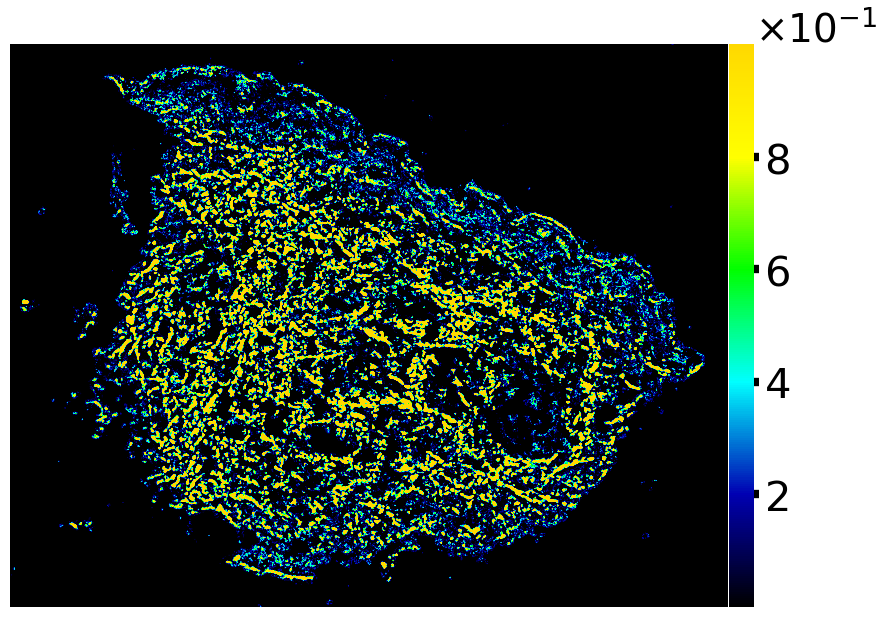

In [151]:
# IMAGES

# Background subtraction and correction
background = gaussian_filter(deg_ret_10, sigma=5)
corrected_image = deg_ret_10 - background
corrected_image = np.clip(corrected_image, 0, None)
adjusted_image = np.rot90(corrected_image, k=3)

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size to match your image

# Show the image
shw = ax.imshow(adjusted_image, vmin=0, vmax=1, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)  # narrower, closer colorbar


# Define tick range and values
tick_values = np.linspace(0.2, 0.8, 4)  # for example: [0.2, 0.4, 0.6, 0.8, 1.0]
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)
cbar.ax.tick_params(labelsize=30, width = 6)
for spine in cbar.ax.spines.values():
    spine.set_visible(False)


# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)

# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)

# Remove axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)

# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 40})
# ax.add_artist(scalebar)

# Prevent tick labels from getting clipped
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 1\\hEDS_ret.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

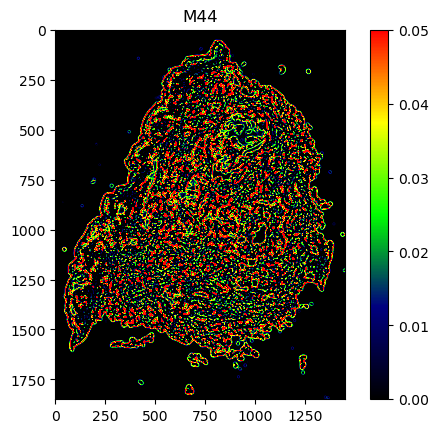

In [35]:
# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(M_10_33, sigma=5)  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = M_10_33 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.01

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.05, cmap=custom_cmap_4)
bar = plt.colorbar(shw)
t = ax.set_title('M44')
plt.show()


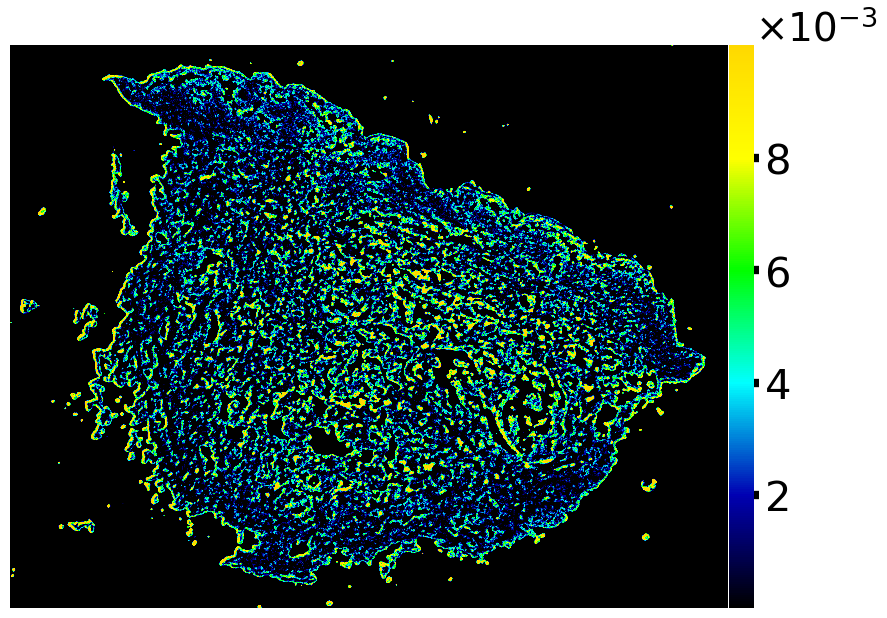

In [105]:
# Diattenuation: Background subtraction and correction
background = gaussian_filter(diattenuation_10, sigma=10)
corrected_image = diattenuation_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Rotate and crop
adjusted_image = np.rot90((corrected_image - 0.0015), k=3)

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Display image with vmin/vmax
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.01, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.002, 0.008, 4)

# Add colorbar with tick range
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)

# Increase tick label font size and line width
cbar.ax.tick_params(labelsize=30, width=6)

# Remove the colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)


# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)

# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 1\\hEDS_diat.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()




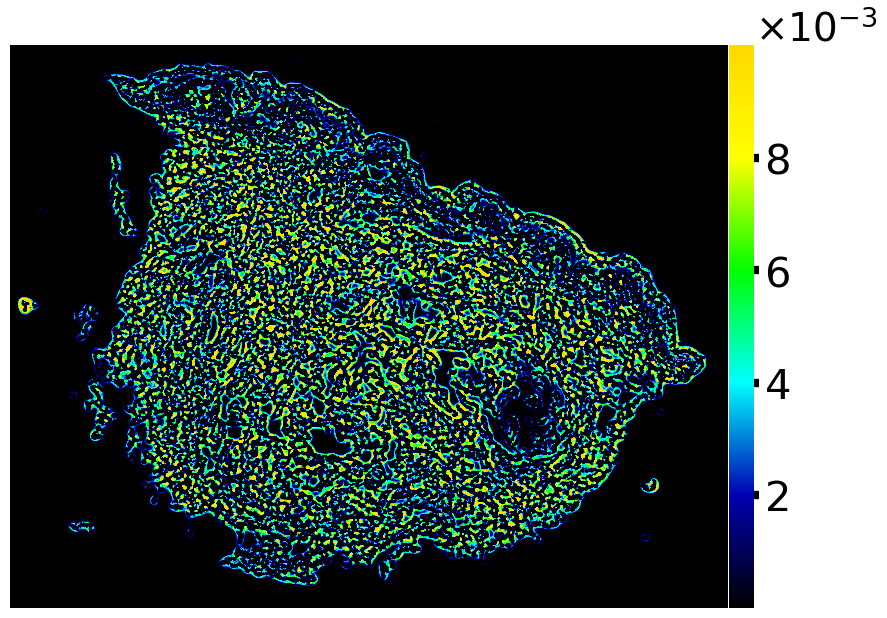

In [106]:
# Depolarization

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(Depol_10, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = Depol_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.002), k =3)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8, 6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.01, cmap= custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.002, 0.008, 4)

# Add colorbar with tick range
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)

# Increase tick label font size and line width
cbar.ax.tick_params(labelsize=30, width=6)

# Remove the colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)


# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)
# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 1\\hEDS_depol.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

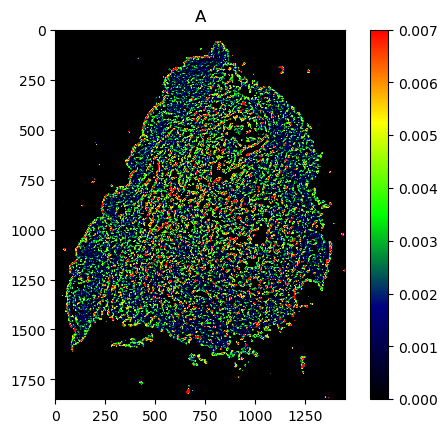

In [38]:
# A

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(A_10, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = A_10 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.002

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.007, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('A')
plt.show()

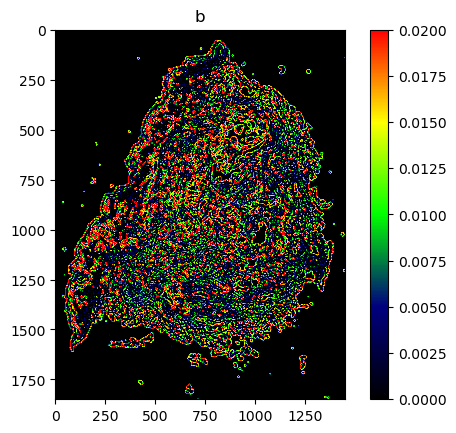

In [39]:
# b

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(b_10, sigma=2, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = b_10 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.003

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.02, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('b')
plt.show()

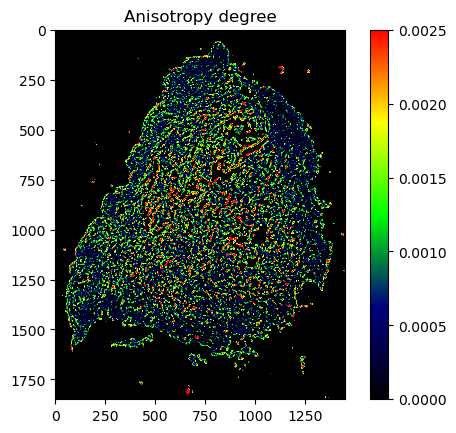

In [40]:
# anisotropy_degree

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(anisotropy_degree_10, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = anisotropy_degree_10 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.001

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.0025, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('Anisotropy degree')
plt.show()

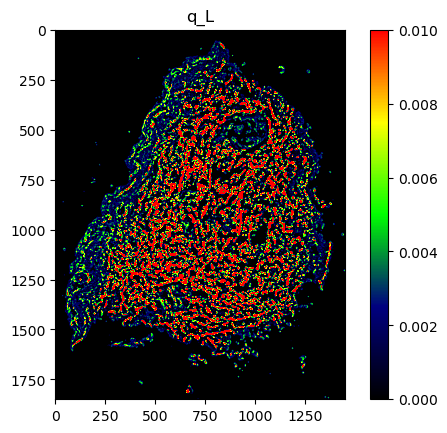

In [41]:
# q_L

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(q_L_10, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = q_L_10 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.01, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('q_L')
plt.show()

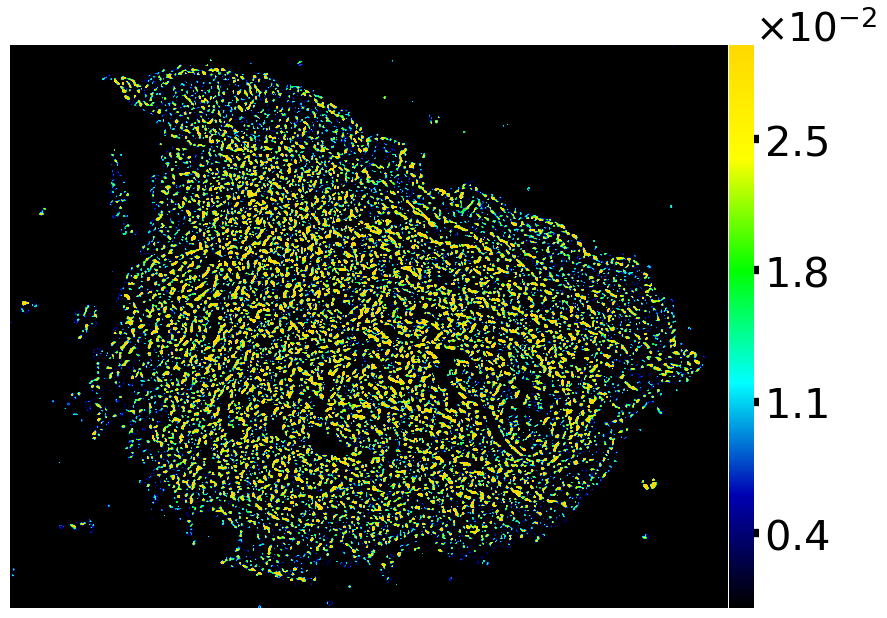

In [112]:
# circular_to_linear

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(circular_to_linear_10, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = circular_to_linear_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.006), k =3)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.03, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.004, 0.025, 4)

# Add colorbar with tick range
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)

# Increase tick label font size and line width
cbar.ax.tick_params(labelsize=30, width=6)

# Remove the colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)


# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)

# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)
# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\hEDS_rL.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()


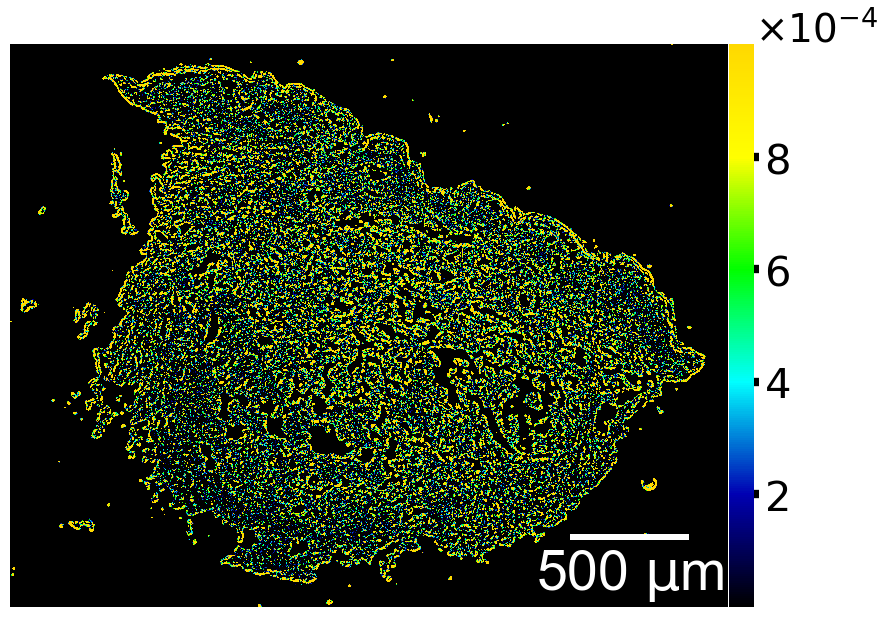

In [150]:
# Linear_polar

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(Linear_polar_10, sigma=5, mode='wrap')

# Subtract the background from the original image
corrected_image = Linear_polar_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Rotate image
adjusted_image = np.rot90((corrected_image - 0.0012), k=3)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8, 6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.001, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.0002, 0.0008, 4)
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)
cbar.ax.tick_params(labelsize=30, width=6)

# Remove colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)

# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)

# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 40})

ax.add_artist(scalebar)

# Final cleanup
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)

# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\hEDS_pL.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()


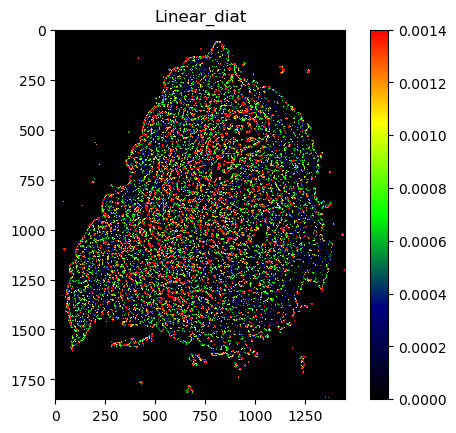

In [44]:
# Linear_diat

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(Linear_diat_10, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = Linear_diat_10 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.0015

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.0014, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('Linear_diat')
plt.show()


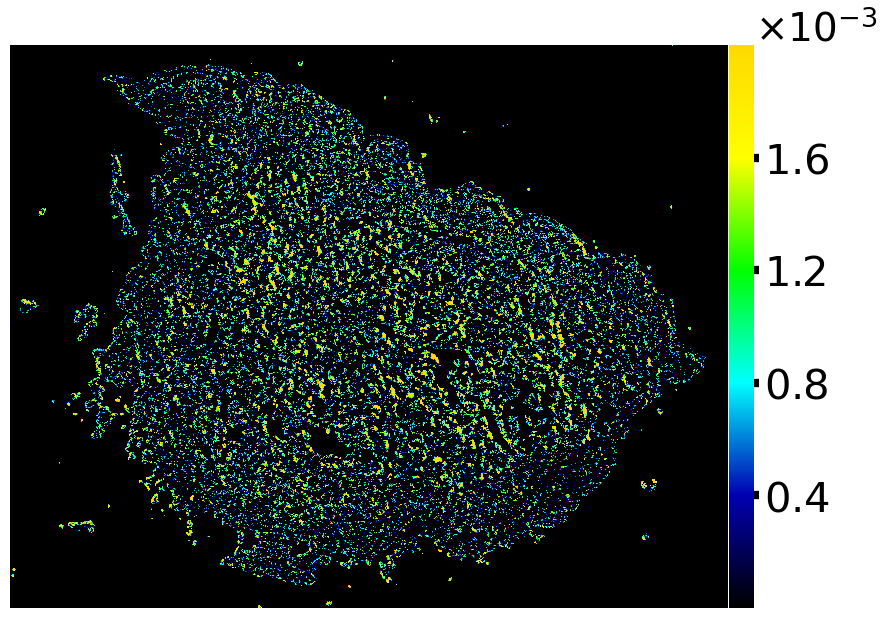

In [121]:
# beta

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(beta_10, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = beta_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0015), k =3)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.002, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.0004, 0.0016, 4)

# Add colorbar with tick range
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)

# Increase tick label font size and line width
cbar.ax.tick_params(labelsize=30, width=6)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)



# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)
# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)

# Remove the colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 2\\hEDS_beta.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

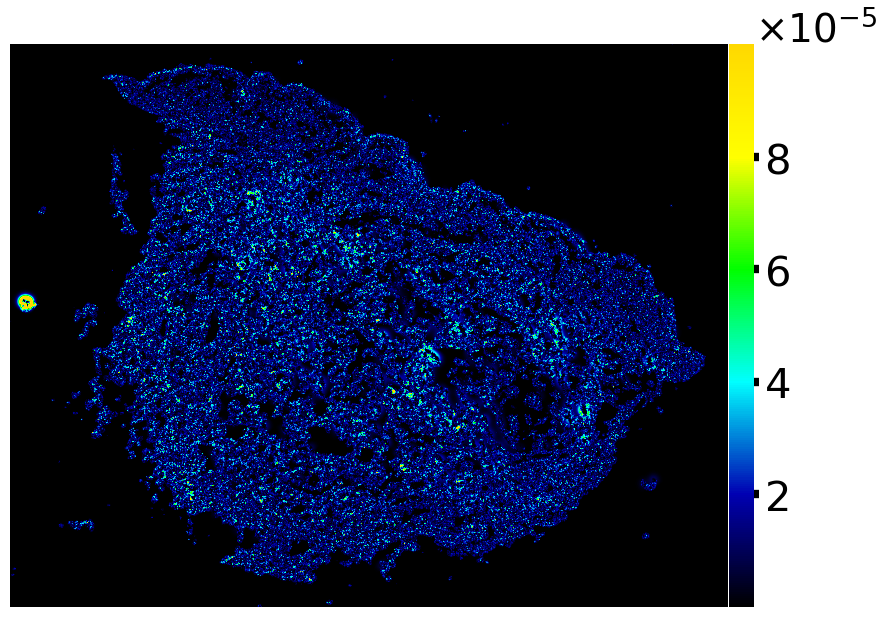

In [122]:
# opt_rot

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(opt_rot_10, sigma=9, mode='wrap')

# Subtract background and clip
corrected_image = opt_rot_10 - background
corrected_image = np.clip(corrected_image, 0, None)
adjusted_image = np.rot90(corrected_image, k=3)

# Plot the image
fig, ax = plt.subplots(figsize=(8, 6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.0001, cmap=custom_cmap_11)

# Attach colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define ticks
tick_values = np.linspace(0.00002, 0.00008, 4)
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)
cbar.ax.tick_params(labelsize=30, width=6)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)



# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)

# Remove colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)
# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)
# Remove image ticks and finalize layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 2\\hEDS_opt_rot.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

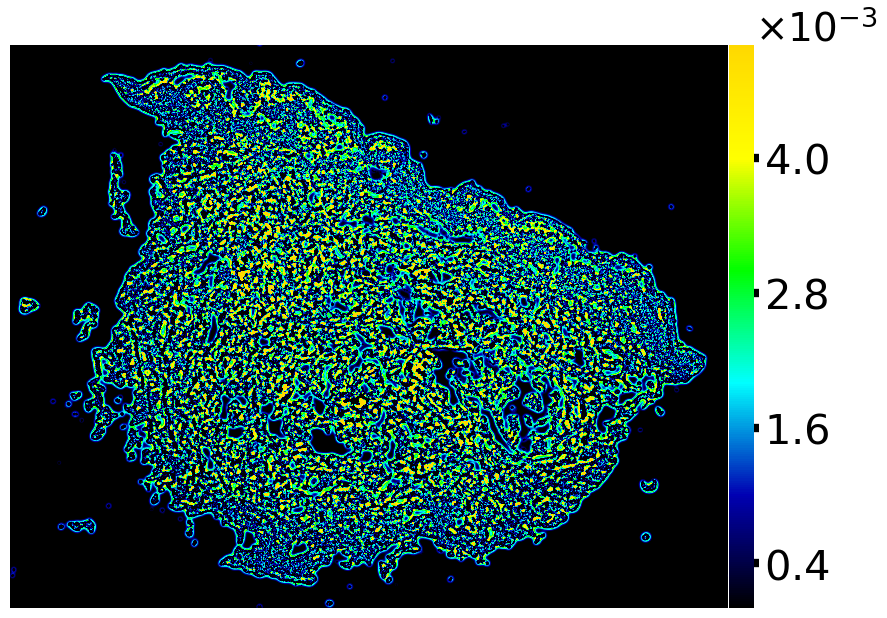

In [125]:
# p_1

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(p_1_10, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = p_1_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0005), k =3)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.005, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.0004, 0.004, 4)

# Add colorbar with tick range
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)

# Increase tick label font size and line width
cbar.ax.tick_params(labelsize=30, width=6)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)

# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)
# Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)
# Remove the colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\hEDS_p1.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

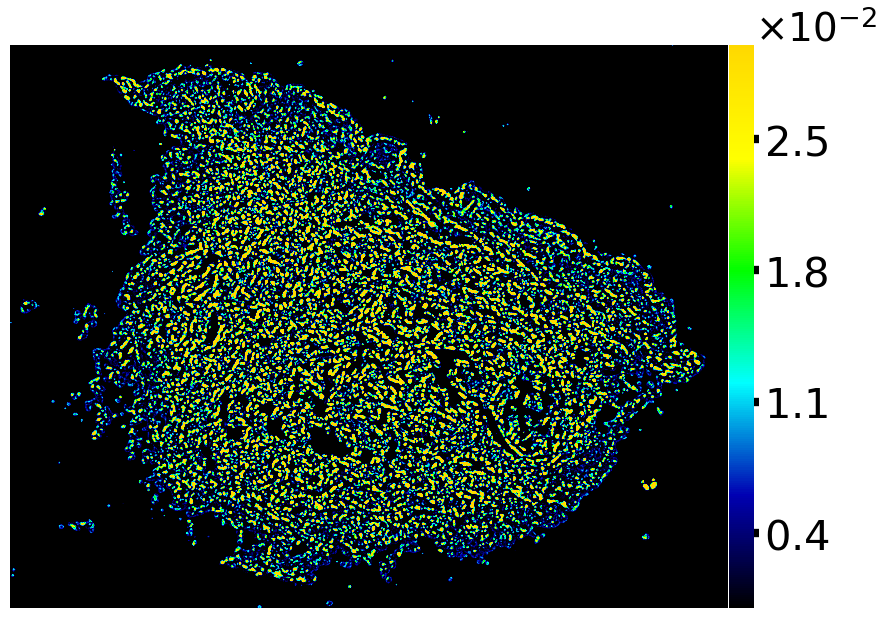

In [129]:
# p_3

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(p_3_10, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = p_3_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0005), k =3)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.03, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.004, 0.025, 4)

# Add colorbar with tick range
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)

# Increase tick label font size and line width
cbar.ax.tick_params(labelsize=30, width=6)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)


# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)
# Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)
# Remove the colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\hEDS_p3.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

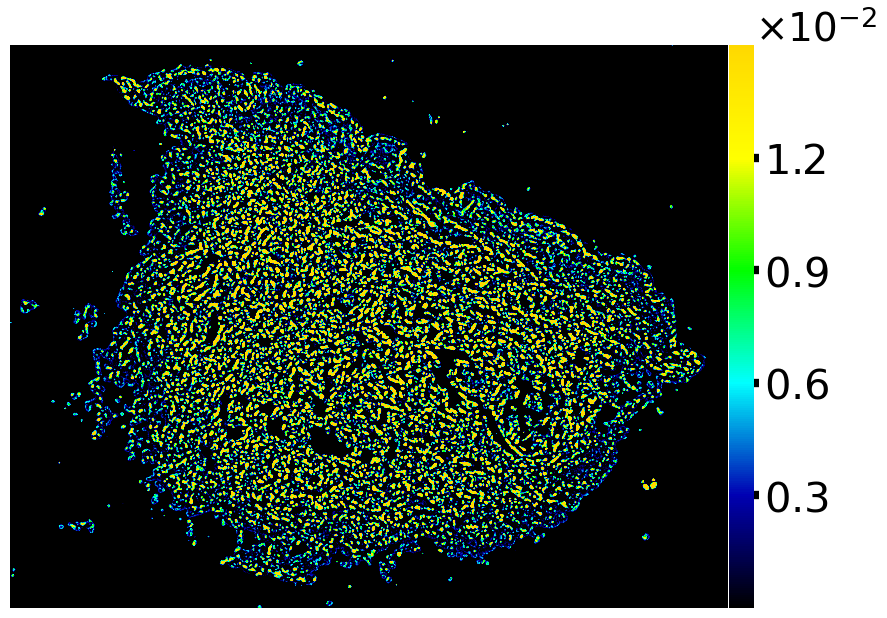

In [146]:
# p_tms

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(p_tms_10, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = p_tms_10 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0008), k =3)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.015, cmap=custom_cmap_11)

# Create divider and attach smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.01)

# Define tick range and values
tick_values = np.linspace(0.003, 0.012, 4)

# Add colorbar with tick range
cbar = fig.colorbar(shw, cax=cax, ticks=tick_values)

# Increase tick label font size and line width
cbar.ax.tick_params(labelsize=30, width=6)

# # Add a scalebar
# pixel_size = 1.625  # micrometers per pixel (update with your actual value)
# scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
#                     length_fraction=0.2, box_alpha=0, color='white', scale_loc='bottom',
#                     font_properties={'family':'Arial','size': 30})

# ax.add_artist(scalebar)

# Use ScalarFormatter to enable scientific notation with order only at the top
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

# Adjust offset text (top label showing the magnitude)
cbar.ax.yaxis.get_offset_text()
cbar.ax.yaxis.get_offset_text().set_size(28)  # Adjust as needed
# cbar.ax.yaxis.get_offset_text().set_weight('bold')

# Get the offset text (the scientific notation like ×10⁻³)
offset_text = cbar.ax.yaxis.get_offset_text()

# Move it to the top-right of the colorbar
offset_text.set_position((1.05, 1.01))  # (x, y) in axes fraction coordinates
offset_text.set_ha('left')              # Align text to the left (visually right-justified)

# Remove the colorbar outline
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# # Set bold font for colorbar tick labels
# bold_font = FontProperties(weight='bold', size=30)
# for label in cbar.ax.get_yticklabels():
#     label.set_fontproperties(bold_font)

# Remove image axis ticks and tighten layout
ax.axis('off')
plt.tight_layout(pad=0)
plt.subplots_adjust(right=0.93)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\hEDS_ptms.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

In [50]:
# HISTOGRAMS for reference#

In [51]:
# M parameters 

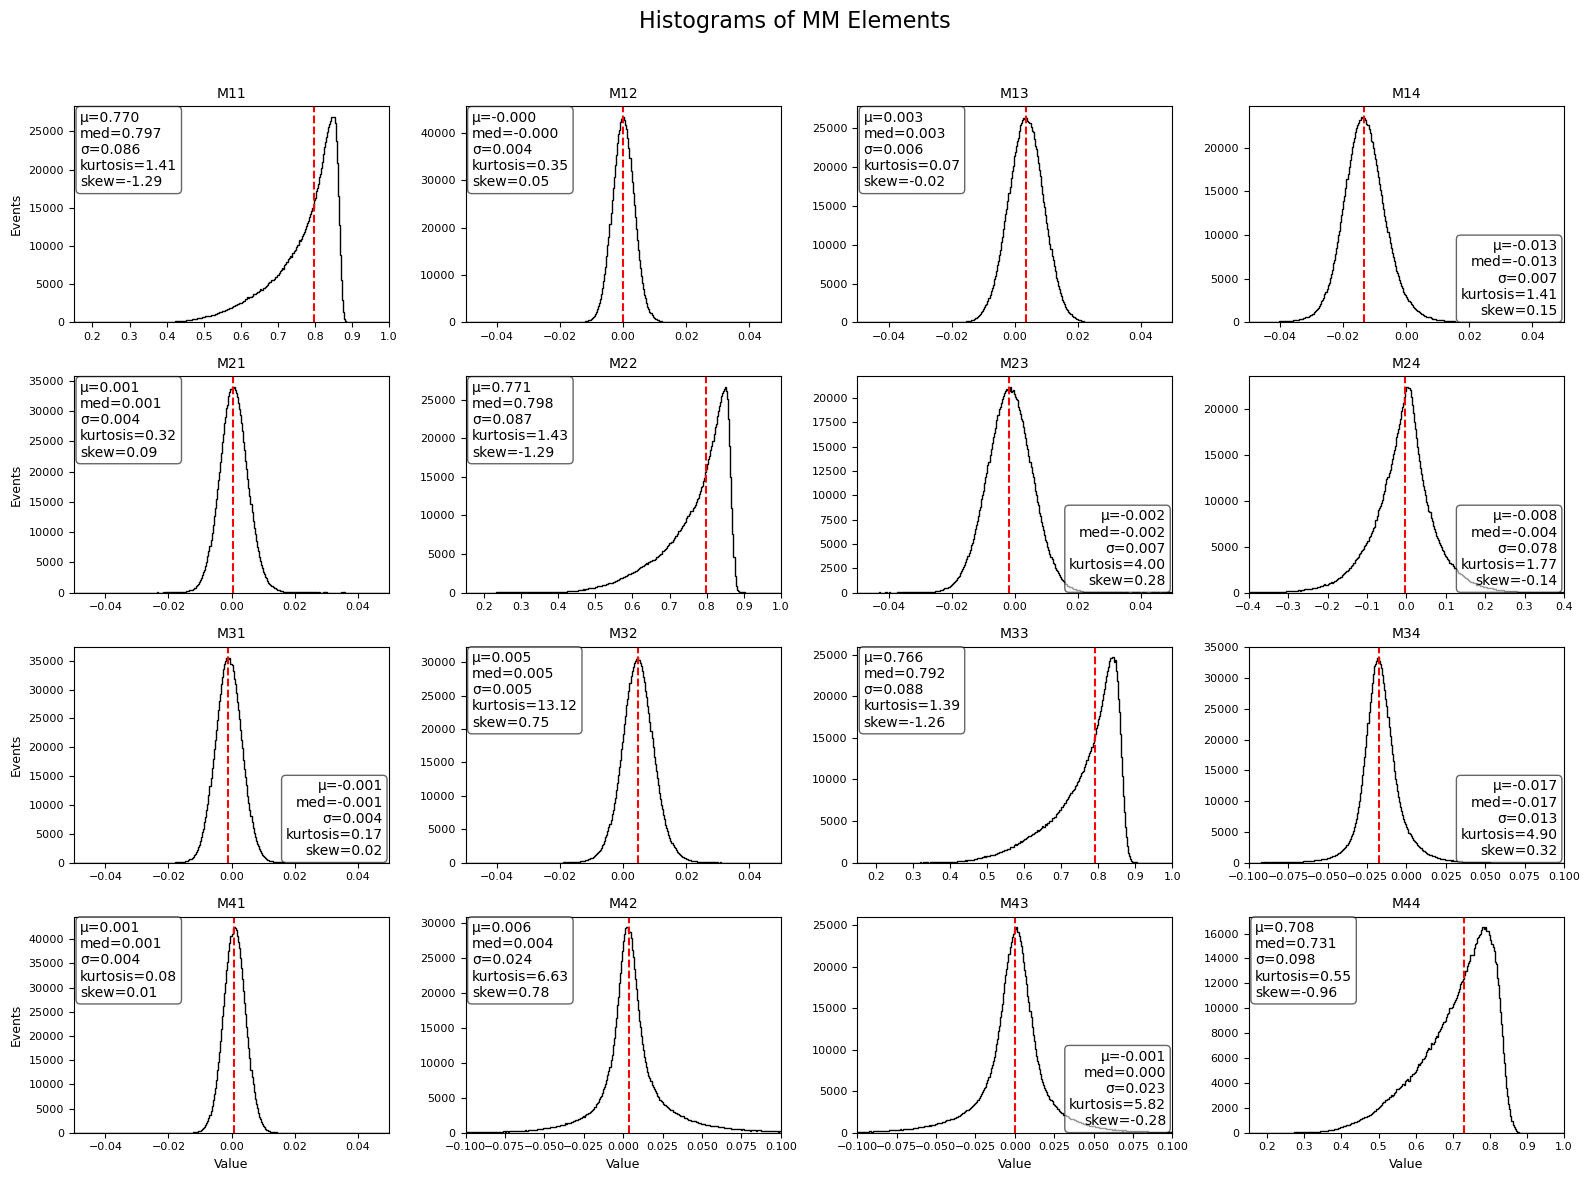

In [52]:
MM_elements = {
    'M11': M_10_00,
    'M12': M_10_01,
    'M13': M_10_02,
    'M14': M_10_03,
    'M21': M_10_10,
    'M22': M_10_11,
    'M23': M_10_12,
    'M24': M_10_13,
    'M31': M_10_20,
    'M32': M_10_21,
    'M33': M_10_22,
    'M34': M_10_23,
    'M41': M_10_30,
    'M42': M_10_31,
    'M43': M_10_32,
    'M44': M_10_33,
}

# Default configuration
default_bins = 300
default_range = (-0.05, 0.05)

# Customisable configuration
custom_config = {
    'M42': {'bins': 300, 'range': (-0.1, 0.1)},
    'M43': {'bins': 300, 'range': (-0.1, 0.1)},
    'M34': {'bins': 300, 'range': (-0.1, 0.1)},
    'M24': {'bins': 300, 'range': (-0.4, 0.4)},
    'M11': {'bins': 300, 'range': (0.15, 1)},
    'M22': {'bins': 300, 'range': (0.15, 1)},
    'M33': {'bins': 300, 'range': (0.15, 1)},
    'M44': {'bins': 300, 'range': (0.15, 1)}
    # Add other specific configs if needed
}

# Create 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle("Histograms of MM Elements", fontsize=16)

for idx, (name, matrix) in enumerate(MM_elements.items()):
    ax = axes[idx // 4, idx % 4]

    # Apply tissue mask to extract only relevant pixels
    tissue_values = matrix[tissue_mask]

    config = custom_config.get(name, {'bins': default_bins, 'range': default_range})

    # Plot histogram only for tissue pixels
    counts, bin_edges, _ = ax.hist(tissue_values, bins=config['bins'], range=config['range'],
                                    color='black', histtype='step')

    # Compute stats
    mean_val, median_val, std_val, kurt_val, skew_val = parameter_stats(matrix, tissue_mask)
    
    # Format and display stats
    stats_text = (
        f"μ={mean_val:.3f}\n"
        f"med={median_val:.3f}\n"
        f"σ={std_val:.3f}\n"
        f"kurtosis={kurt_val:.2f}\n"
        f"skew={skew_val:.2f}"
    )
    # Find quadrant with least activity
    half = len(counts) // 2
    q1 = np.mean(counts[:half // 2])      # top-left
    q2 = np.mean(counts[half // 2:half])  # top-right
    q3 = np.mean(counts[half:half + half // 2])  # bottom-left
    q4 = np.mean(counts[half + half // 2:])      # bottom-right
    
    quadrant_scores = {
        'top-left': q1,
        'top-right': q2,
        'bottom-left': q3,
        'bottom-right': q4
    }
    best_quadrant = min(quadrant_scores, key=quadrant_scores.get)
    
    # Map best quadrant to axes-relative position
    positions = {
        'top-left': (0.02, 0.98, 'left', 'top'),
        'top-right': (0.98, 0.98, 'right', 'top'),
        'bottom-left': (0.02, 0.02, 'left', 'bottom'),
        'bottom-right': (0.98, 0.02, 'right', 'bottom'),
    }
    x, y, ha, va = positions[best_quadrant]
    
    # Place text at chosen quadrant
    ax.text(
        x, y, stats_text,
        transform=ax.transAxes,
        fontsize=10, va=va, ha=ha,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
    )
    ax.axvline(median_val, color = 'red', linestyle = '--')

    ax.set_title(name, fontsize=10)
    ax.set_xlim(config['range'])
    ax.tick_params(labelsize=8)

    if idx % 4 == 0:
        ax.set_ylabel('Events', fontsize=9)
    if idx // 4 == 3:
        ax.set_xlabel('Value', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [53]:
# p parameters

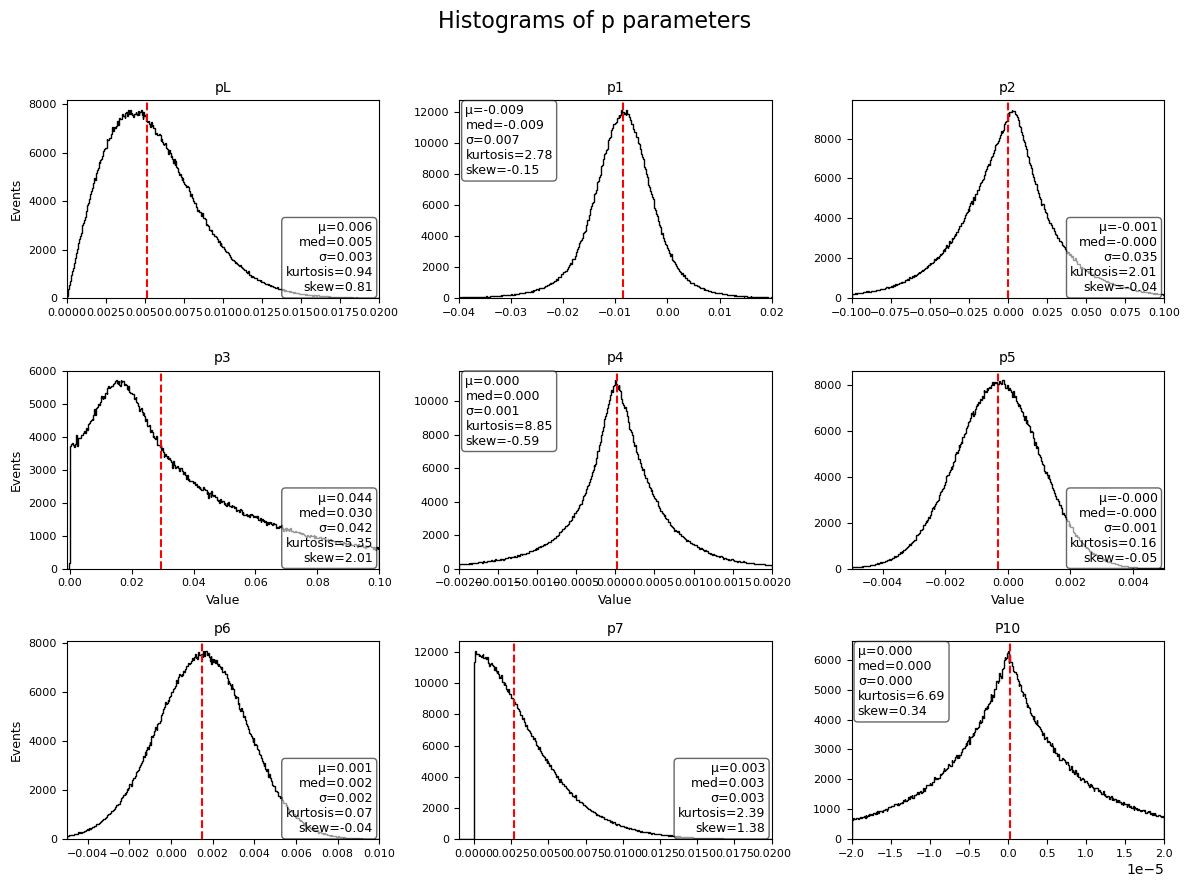

In [54]:
p_elements = {
    'pL': p_L_10,
    'p1': p_1_10,
    'p2': p_2_10,
    'p3': p_3_10,
    'p4': p_4_10,
    'p5': p_5_10,
    'p6': p_6_10,
    'p7': p_7_10,
    'P10': p_8_10
}

# Default configuration
default_bins = 400
default_range = (-0.005, 0.005)

# Customisable configuration
custom_config = {
    'pL': {'bins': 400, 'range': (0, 0.02)},
    'p1': {'bins': 400, 'range': (-0.04, 0.02)},
    'p2': {'bins': 400, 'range': (-0.1, 0.1)},
    'p3': {'bins': 400, 'range': (-0.001, 0.1)},
    'p4': {'bins': 400, 'range': (-0.002, 0.002)},
    'p7': {'bins': 400, 'range': (-0.001, 0.02)},
    'p6': {'bins': 400, 'range': (-0.005, 0.01)},
    'P10': {'bins': 400, 'range': (-2E-05, 2E-05)}
    # Add other specific configs if needed
}
# Create 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
fig.suptitle("Histograms of p parameters", fontsize=16)

for idx, (name, matrix) in enumerate(p_elements.items()):
    ax = axes[idx // 3, idx % 3]

    # Apply tissue mask to extract only relevant pixels
    tissue_values = matrix[tissue_mask]

    config = custom_config.get(name, {'bins': default_bins, 'range': default_range})

    # Plot histogram only for tissue pixels
    counts, bin_edges, _ = ax.hist(tissue_values, bins=config['bins'], range=config['range'],
                                    color='black', histtype='step')

    # Compute stats
    mean_val, median_val, std_val, kurt_val, skew_val = parameter_stats(matrix, tissue_mask)
    
    # Format and display stats
    stats_text = (
        f"μ={mean_val:.3f}\n"
        f"med={median_val:.3f}\n"
        f"σ={std_val:.3f}\n"
        f"kurtosis={kurt_val:.2f}\n"
        f"skew={skew_val:.2f}"
    )
    # Find quadrant with least activity
    half = len(counts) // 2
    q1 = np.mean(counts[:half // 2])      # top-left
    q2 = np.mean(counts[half // 2:half])  # top-right
    q3 = np.mean(counts[half:half + half // 2])  # bottom-left
    q4 = np.mean(counts[half + half // 2:])      # bottom-right
    
    quadrant_scores = {
        'top-left': q1,
        'top-right': q2,
        'bottom-left': q3,
        'bottom-right': q4
    }
    best_quadrant = min(quadrant_scores, key=quadrant_scores.get)
    
    # Map best quadrant to axes-relative position
    positions = {
        'top-left': (0.02, 0.98, 'left', 'top'),
        'top-right': (0.98, 0.98, 'right', 'top'),
        'bottom-left': (0.02, 0.02, 'left', 'bottom'),
        'bottom-right': (0.98, 0.02, 'right', 'bottom'),
    }
    x, y, ha, va = positions[best_quadrant]
    
    # Place text at chosen quadrant
    ax.text(
        x, y, stats_text,
        transform=ax.transAxes,
        fontsize=9, va=va, ha=ha,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
    )
    ax.axvline(median_val, color = 'red', linestyle = '--')

    ax.set_title(name, fontsize=10)
    ax.set_xlim(config['range'])
    ax.tick_params(labelsize=8)

    if idx % 3 == 0:
        ax.set_ylabel('Events', fontsize=9)
    if idx // 3 == 1:
        ax.set_xlabel('Value', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


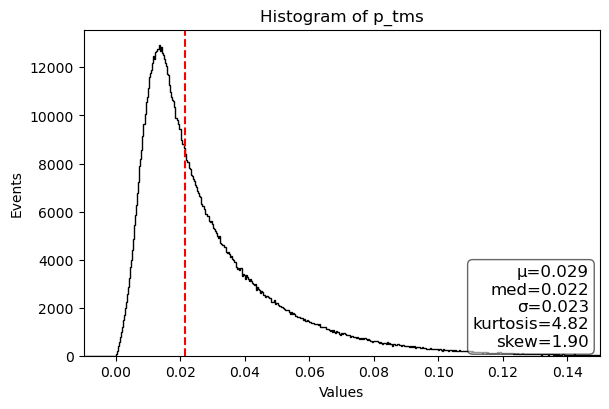

In [55]:
# p_tms
num_bins = 500
bin_range = (-0.01, 0.15)

# Prepare data
tissue_values = p_tms_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_p_tms_10:.3f}\n"
    f"med={med_p_tms_10:.3f}\n"
    f"σ={std_p_tms_10:.3f}\n"
    f"kurtosis={kurt_p_tms_10:.2f}\n"
    f"skew={skew_p_tms_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_p_tms_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of p_tms')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()


In [56]:
# Retardance #

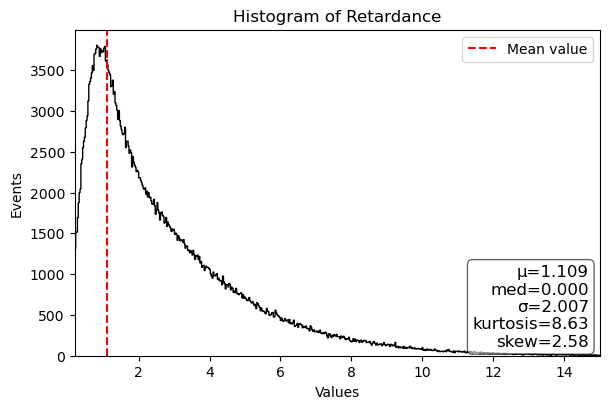

In [57]:
num_bins = 600
bin_range = (0.2,15)

# Prepare data
tissue_values = deg_ret_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_deg_ret_10:.3f}\n"
    f"med={med_deg_ret_10:.3f}\n"
    f"σ={std_deg_ret_10:.3f}\n"
    f"kurtosis={kurt_deg_ret_10:.2f}\n"
    f"skew={skew_deg_ret_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(avg_deg_ret_10, color='red', linestyle='--', label = 'Mean value')

# Title and limits
ax.set_title('Histogram of Retardance')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.legend(loc = 'upper right')
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [58]:
print(tissue_values)

[0. 0. 0. ... 0. 0. 0.]


In [59]:
print(deg_ret_10)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [60]:
# Diattenuation #

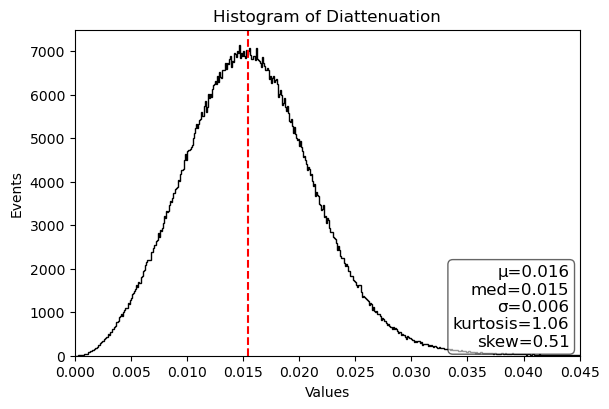

In [61]:
num_bins = 500
bin_range = (0, 0.045)

# Prepare data
tissue_values = diattenuation_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_diattenuation_10:.3f}\n"
    f"med={med_diattenuation_10:.3f}\n"
    f"σ={std_diattenuation_10:.3f}\n"
    f"kurtosis={kurt_diattenuation_10:.2f}\n"
    f"skew={skew_diattenuation_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_diattenuation_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of Diattenuation')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()


In [62]:
# Depolarization #

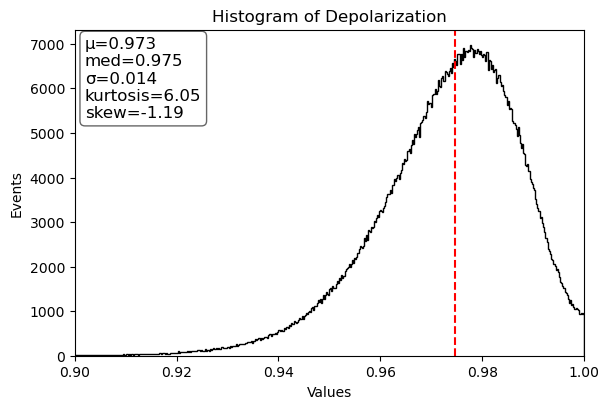

In [63]:
num_bins = 500
bin_range = (0.9,1)


# Prepare data
tissue_values = Depol_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_Depol_10:.3f}\n"
    f"med={med_Depol_10:.3f}\n"
    f"σ={std_Depol_10:.3f}\n"
    f"kurtosis={kurt_Depol_10:.2f}\n"
    f"skew={skew_Depol_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_Depol_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of Depolarization')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [64]:
# A #

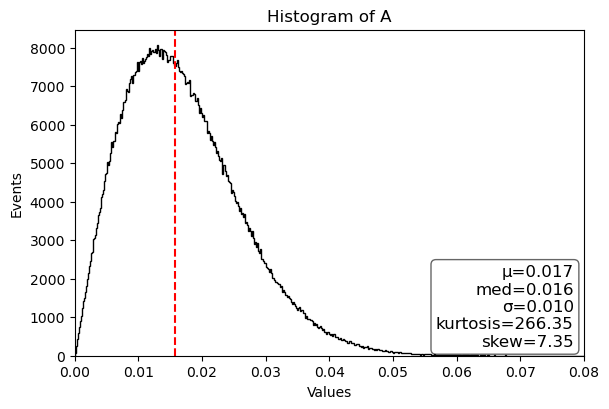

In [65]:
num_bins = 500
bin_range = (0,0.08)

# Prepare data
tissue_values = A_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_A_10:.3f}\n"
    f"med={med_A_10:.3f}\n"
    f"σ={std_A_10:.3f}\n"
    f"kurtosis={kurt_A_10:.2f}\n"
    f"skew={skew_A_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_A_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of A')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [66]:
# b #

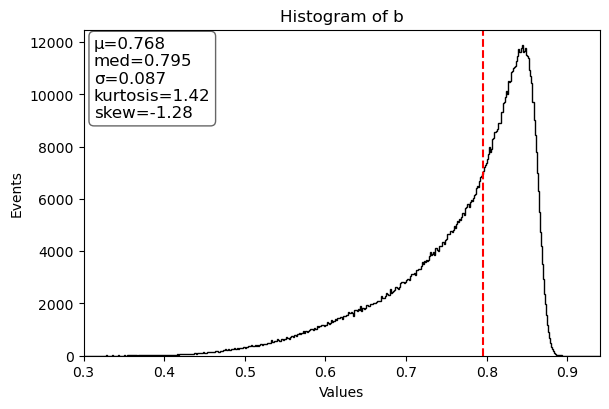

In [67]:
num_bins = 500
bin_range = (0.3,0.94)

# Prepare data
tissue_values = b_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_b_10:.3f}\n"
    f"med={med_b_10:.3f}\n"
    f"σ={std_b_10:.3f}\n"
    f"kurtosis={kurt_b_10:.2f}\n"
    f"skew={skew_b_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_b_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of b')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [68]:
# anisotropy degree #

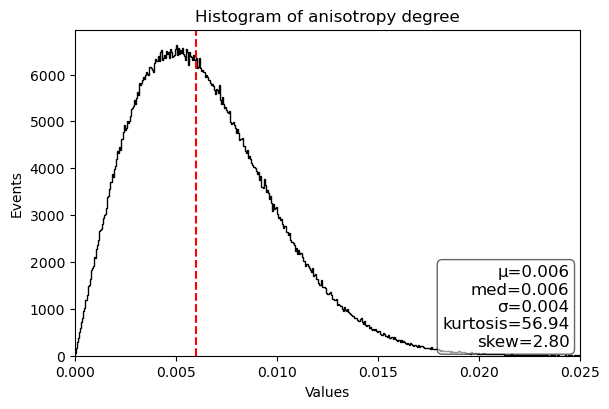

In [69]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = anisotropy_degree_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_anisotropy_degree_10:.3f}\n"
    f"med={med_anisotropy_degree_10:.3f}\n"
    f"σ={std_anisotropy_degree_10:.3f}\n"
    f"kurtosis={kurt_anisotropy_degree_10:.2f}\n"
    f"skew={skew_anisotropy_degree_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_anisotropy_degree_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of anisotropy degree')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [70]:
# q_L #

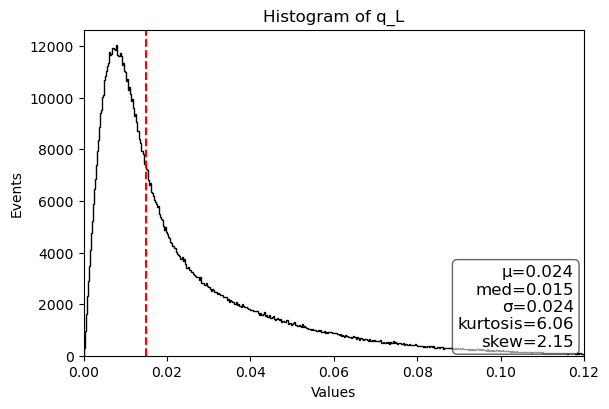

In [71]:
num_bins = 500
bin_range = (0,0.12)

# Prepare data
tissue_values = q_L_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_q_L_10:.3f}\n"
    f"med={med_q_L_10:.3f}\n"
    f"σ={std_q_L_10:.3f}\n"
    f"kurtosis={kurt_q_L_10:.2f}\n"
    f"skew={skew_q_L_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_q_L_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of q_L')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [72]:
# x #

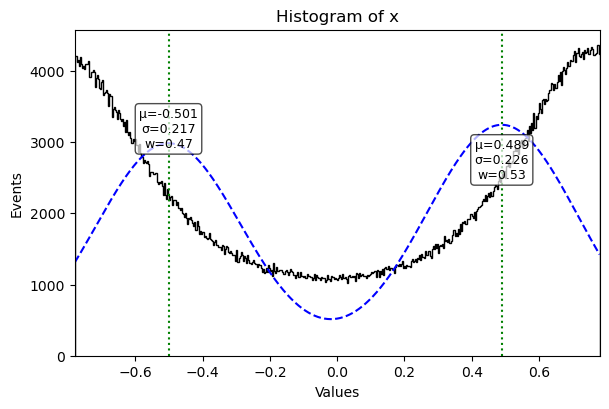

In [73]:
num_bins = 500
bin_range = (-0.78,0.78)

# Prepare data
tissue_values = x_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Fit a 2-component GMM
values_reshaped = tissue_values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=0, means_init=np.array([[-0.78], [0.7]]))
gmm.fit(values_reshaped)
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_

# Plot GMM PDF scaled to histogram
x = np.linspace(*bin_range, 1000).reshape(-1, 1)
gmm_pdf = np.exp(gmm.score_samples(x))
ax.plot(x, gmm_pdf * len(tissue_values) * (bin_range[1] - bin_range[0]) / num_bins,
        color='blue', linestyle='--', label='GMM fit')

# Annotate GMM components
for i in range(2):
    ax.axvline(means[i], color='green', linestyle=':', label=f'Mode {i+1} μ={means[i]:.3f}')
    ax.text(
        means[i], max(counts) * 0.8 - i * max(counts) * 0.1,
        f"μ={means[i]:.3f}\nσ={stds[i]:.3f}\nw={weights[i]:.2f}",
        fontsize=9, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )


# Title and limits
ax.set_title('Histogram of x')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [74]:
print(tissue_values)
print(values_reshaped)

[-0.67962551 -0.31810205  0.1044122  ... -0.66918989 -0.41573478
  0.10009503]
[[-0.67962551]
 [-0.31810205]
 [ 0.1044122 ]
 ...
 [-0.66918989]
 [-0.41573478]
 [ 0.10009503]]


In [75]:
# Circular to linear #

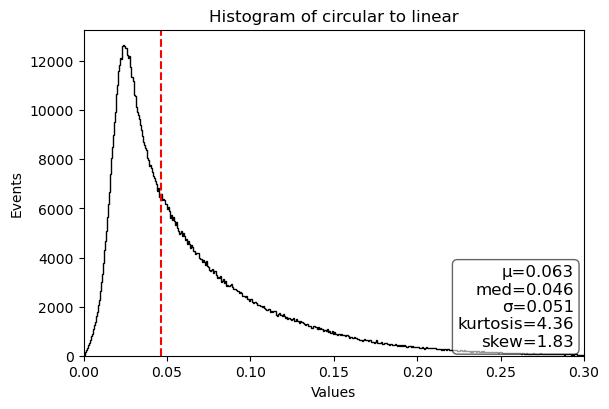

In [76]:
num_bins = 500
bin_range = (0,0.3)

# Prepare data
tissue_values = circular_to_linear_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_circular_to_linear_10:.3f}\n"
    f"med={med_circular_to_linear_10:.3f}\n"
    f"σ={std_circular_to_linear_10:.3f}\n"
    f"kurtosis={kurt_circular_to_linear_10:.2f}\n"
    f"skew={skew_circular_to_linear_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_circular_to_linear_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of circular to linear')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [77]:
# Linear_polar #

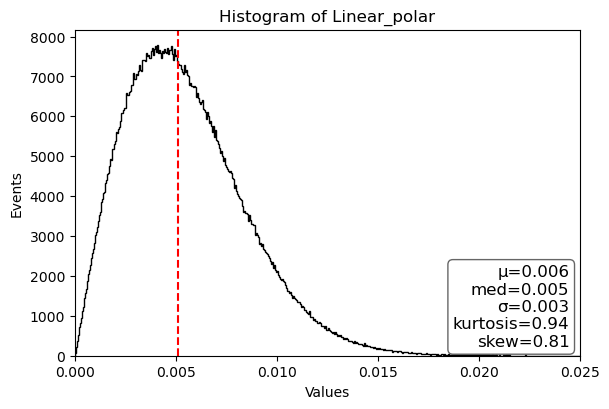

In [78]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = Linear_polar_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_Linear_polar_10:.3f}\n"
    f"med={med_Linear_polar_10:.3f}\n"
    f"σ={std_Linear_polar_10:.3f}\n"
    f"kurtosis={kurt_Linear_polar_10:.2f}\n"
    f"skew={skew_Linear_polar_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_Linear_polar_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of Linear_polar')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [79]:
# Linear_diat #

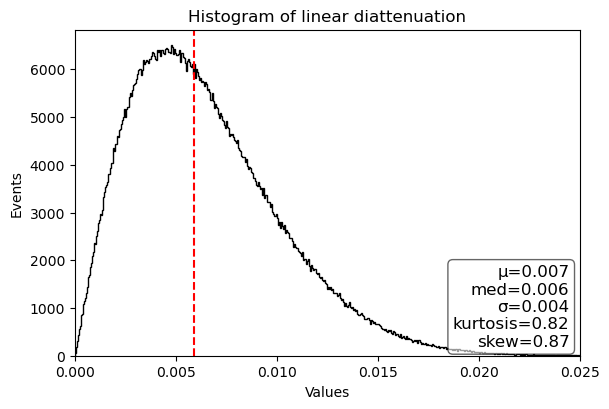

In [80]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = Linear_diat_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_Linear_diat_10:.3f}\n"
    f"med={med_Linear_diat_10:.3f}\n"
    f"σ={std_Linear_diat_10:.3f}\n"
    f"kurtosis={kurt_Linear_diat_10:.2f}\n"
    f"skew={skew_Linear_diat_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_Linear_diat_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of linear diattenuation')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [81]:
# beta #

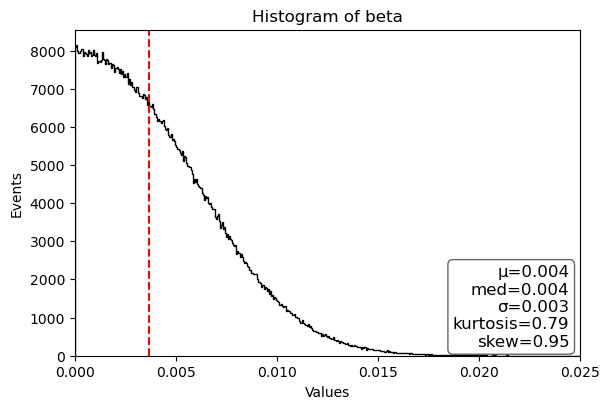

In [82]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = beta_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_beta_10:.3f}\n"
    f"med={med_beta_10:.3f}\n"
    f"σ={std_beta_10:.3f}\n"
    f"kurtosis={kurt_beta_10:.2f}\n"
    f"skew={skew_beta_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_beta_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of beta')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [83]:
# opt_rot #

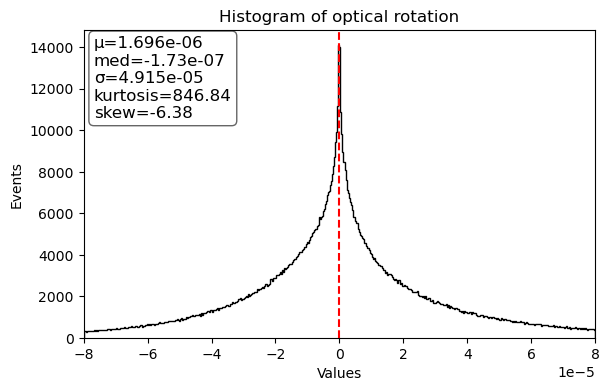

In [84]:
num_bins = 500
bin_range = (-8E-05,8E-05)

# Prepare data
tissue_values = opt_rot_10[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={np.format_float_scientific(avg_opt_rot_10, precision=3)}\n"
    f"med={np.format_float_scientific(med_opt_rot_10, precision=3)}\n"
    f"σ={np.format_float_scientific(std_opt_rot_10, precision=3)}\n"
    f"kurtosis={kurt_opt_rot_10:.2f}\n"
    f"skew={skew_opt_rot_10:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_opt_rot_10, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of optical rotation')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()